In [1]:
# Import libraries
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from natsort import natsorted
from skimage import exposure
%matplotlib inline

In [2]:
# Load mtx, dist from pickle file saved
with open('calibration.p', mode='rb') as file:
    calibration = pickle.load(file)
    mtx = calibration["mtx"]
    dist = calibration["dist"]

In [3]:
# Functions
def read_img(img):
    return mpimg.imread(img)

def fix_distortion(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def normalize(sobel_in):
    return np.uint8(255 * sobel_in / np.max(sobel_in))

def histo(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)

def eq_hist(img):
    return cv2.equalizeHist(img)

def sigmoid(img):
    return exposure.adjust_sigmoid(img)

def adjust_intensity(img):
    return exposure.rescale_intensity(img)

def adapthist(img):
    return exposure.equalize_adapthist(img)

def roi(img, vert = 'warped'):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #define vertices
    shape = img.shape
    if vert == 'warped':
        vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                          (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)
    elif vert == 'unwarped':
        # FROM https://github.com/wonjunee/Advanced-Lane-Finding/blob/master/Advanced-Lane-Finding-Submission.ipynb
        # Defining vertices for marked area
        imshape = img.shape
        left_bottom = (100, imshape[0])
        right_bottom = (imshape[1]-20, imshape[0])
        apex1 = (610, 410)
        apex2 = (680, 410)
        inner_left_bottom = (310, imshape[0])
        inner_right_bottom = (1150, imshape[0])
        inner_apex1 = (700,480)
        inner_apex2 = (650,480)
        vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
#     ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def sobel_helper(img, orient = 'x', k = 3):
    if orient == 'x':
        return cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=k)
    if orient =='y':
        return cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=k)

def binary_output(output, thresh=(0, 255)):
    temp = np.zeros_like(output)
    temp[(output >= thresh[0]) & (output <= thresh[1])] = 1
    return temp


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = grayscale(img)

    if orient =='x':
        sobel = sobel_helper(gray, 'x', sobel_kernel)
        abs_sobel = np.absolute(sobel)
    if orient =='y':
        sobel = sobel_helper(gray, 'y', sobel_kernel)
        abs_sobel = np.absolute(sobel)

    norm_sobel = normalize(abs_sobel)

    output = binary_output(norm_sobel, thresh)

    return output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    gray = grayscale(img)

    sobelx = sobel_helper(gray, 'x', sobel_kernel)
    sobely = sobel_helper(gray, 'y', sobel_kernel)

    mag_sobel = np.sqrt((sobelx ** 2) + (sobely ** 2))

    norm_sobel = normalize(mag_sobel)

    output = binary_output(norm_sobel, mag_thresh)

    return output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    gray = grayscale(img)

    sobelx = sobel_helper(gray, 'x', sobel_kernel)
    sobely = sobel_helper(gray, 'y', sobel_kernel)

    grad_dir = np.arctan2(np.abs(sobely), np.abs(sobelx))

    output = binary_output(grad_dir, thresh)

    return output

def color_space(img, color = 'HLS', thresh=(0,255), selection = 0):
    
    if color == 'RGB':
        pass
    else:
        color_dict = {'HLS': 53, 'GRAY': 7, 'XYZ': 33, 'HSV': 41, 
                      'LAB': 45, 'LUV': 51, 'YUV': 83, 'YCrCb': 37}

        img = cv2.cvtColor(img, color_dict[color])
    
    channel_selection = selection
    channel = img[:,:,channel_selection]
    
    binary = binary_output(channel, thresh)
    
    return binary

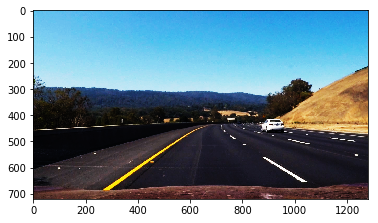

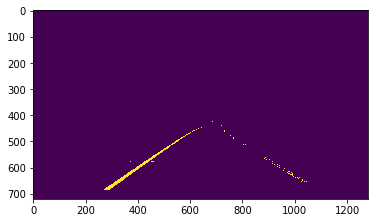

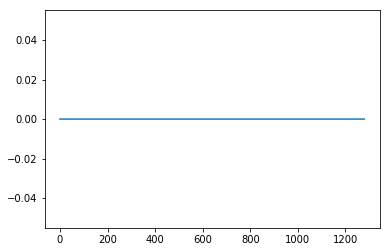

In [4]:
image = read_img('test_images/test3.jpg')

def masking(img):
#     img = sigmoid(img)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
#     grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(0, 255))
#     mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(150, 200))
    dir_binary = dir_threshold(img, sobel_kernel=9, thresh=(0.2, 1.5))
    hls_s = color_space(img, color='HLS', thresh=(100,255), selection=2)
    hls_l = color_space(img, color='HLS', thresh=(120,255), selection=1)
    rgb_r = color_space(img, 'RGB', thresh=(150,255), selection = 0)
    rgb_g = color_space(img, 'RGB', thresh=(150,255), selection = 1)
    luv_l = color_space(img, 'LUV', thresh=(225,255), selection = 0)
    lab_b = color_space(img, 'LAB', thresh=(155,200), selection = 2)
#     yuv_y = color_space(img, 'YUV', thresh=(150,255), selection = 0)
#     hsv_v = color_space(img, 'HSV', thresh=(30,125), selection = 2)
#     hsv_s = color_space(img, 'HSV', thresh=(0,5), selection = 1)
#     hsv_h = color_space(img, 'HSV', thresh=(70,250), selection = 0)
#     ycr_y = color_space(img, 'YCrCb', thresh=(120,150), selection =1)
    combined_1 = np.zeros_like(dir_binary)
    combined_1[(((rgb_r==1) & (rgb_g==1)) & (hls_l==1)) & (((hls_s==1) | ((gradx==1) & (dir_binary==1))))]=1
    combined_2 = np.zeros_like(rgb_r)
#     combined_2[((rgb == 1) | (hls == 1)) | (gradx == 1) & ((dir_binary == 1))] = 1
    combined_2[(rgb_r == 1) | (hls_s == 1)] = 1
    combined_3 = np.zeros_like(dir_binary)
    combined_3[(luv_l == 1) | (lab_b == 1)] = 1

#     combined_2 = roi(combined_2, vertices)
    
    return combined_1
# print (cv2.COLOR_RGB2YCrCb)

adjusted = (sigmoid(image))
# print (adjusted[1])
plt.imshow(adjusted)
plt.show()
masked = roi(masking(adjusted), 'unwarped')
plt.imshow(masked)
plt.show()

histogram = histo(masked)
# plt.xlim(0,1280)
# plt.ylim(720,0)
plt.plot(histogram)
plt.show()

In [5]:
test_images = natsorted(os.listdir('test_images'))

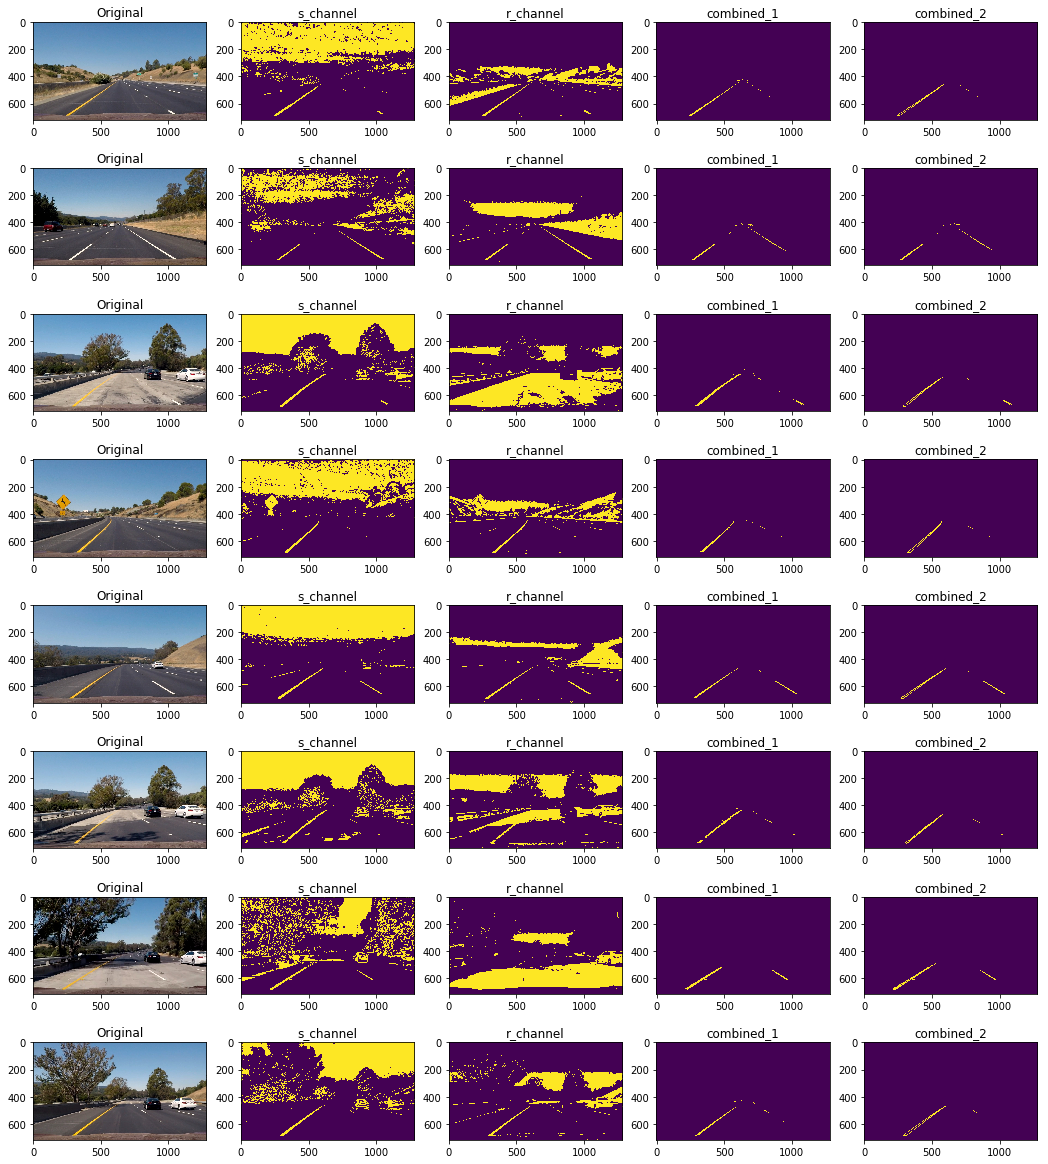

In [6]:
# Find thresholds

plt.figure(figsize=(18,21))
plot_titles = ['Original', 's_channel', 'r_channel', 'combined_1', 'combined_2']

for i, img in enumerate(test_images):
    img = read_img('test_images/' + img)
#     img = sigmoid(img)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(150, 200))
    dir_binary = dir_threshold(img, sobel_kernel=9, thresh=(0.2, 1.5))
    hls_s = color_space(img, color='HLS', thresh=(100,255), selection=2)
    hls_l = color_space(img, color='HLS', thresh=(120,255), selection=1)
    rgb_r = color_space(img, 'RGB', thresh=(150,255), selection = 0)
    rgb_g = color_space(img, 'RGB', thresh=(150,255), selection = 1)
    luv_l = color_space(img, 'LUV', thresh=(225,255), selection = 0)
    lab_b = color_space(img, 'LAB', thresh=(155,200), selection = 2)
    yuv_y = color_space(img, 'YUV', thresh=(150,255), selection = 0)
    hsv_v = color_space(img, 'HSV', thresh=(30,125), selection = 2)
    hsv_s = color_space(img, 'HSV', thresh=(0,5), selection = 1)
    hsv_h = color_space(img, 'HSV', thresh=(70,250), selection = 0)
    ycr_y = color_space(img, 'YCrCb', thresh=(120,150), selection =1)
    combined_1 = np.zeros_like(dir_binary)
    combined_1[(((rgb_r==1) & (rgb_g==1)) & (hls_l==1)) & (((hls_s==1) | ((gradx==1) & (dir_binary==1))))]=1
    combined_2 = np.zeros_like(rgb_r)
#     combined_2[((rgb == 1) | (hls == 1)) | (gradx == 1) & ((dir_binary == 1))] = 1
    combined_2[(rgb_r == 1) | (hls_s == 1)] = 1
    combined_3 = np.zeros_like(dir_binary)
    combined_3[(luv_l == 1) | (lab_b == 1)] = 1
    

    combined_1 = roi(combined_1, 'unwarped')
    combined_2 = roi(combined_2, 'unwarped')
    combined_3 = roi(combined_3, 'unwarped')
    
    mask_list = [img, hls_s, rgb_r, combined_1, combined_3]
    
    for k in range(5):
        plt.subplot(len(test_images), 5, k+1+i*5)
        plt.imshow(mask_list[k])
        plt.title(plot_titles[k])

        
plt.show()

In [7]:
def warp(img):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    top_left=np.array([corners[0,0],0])
    top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
#     src = np.float32([[570, 455], [790, 455], [1180, 720], [200, 720]])
    dst = np.float32([corners[0]+offset,top_left+offset,top_right-offset ,corners[3]-offset])    
#     dst = np.float32([[200, 0], [1180, 0], [1180, 720], [200, 720]])
#     if tobird:
    M = cv2.getPerspectiveTransform(src, dst)
#     else:
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M, src, dst, Minv

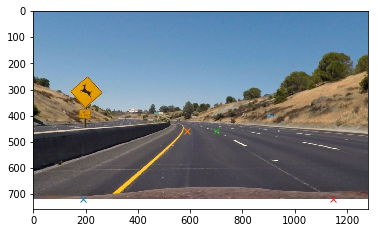

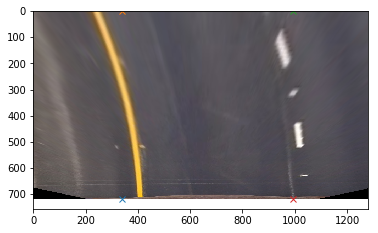

In [8]:
warped_image = read_img('test_images/test2.jpg')
warped_image = fix_distortion(warped_image)
plt.imshow(warped_image)
warped_image, M, src, dst, Minv = warp(warped_image)
for i in range(4):
    plt.plot(src[i][0], src[i][1], 'x')
plt.show()
plt.imshow(warped_image)
for i in range(4):
    plt.plot(dst[i][0], dst[i][1], 'x')
plt.show()

straight_lines1.jpg


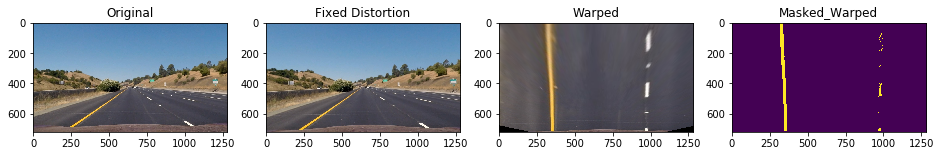

straight_lines2.jpg


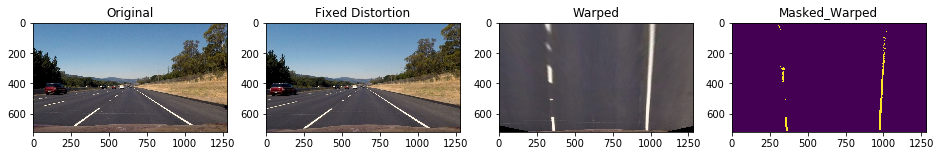

test1.jpg


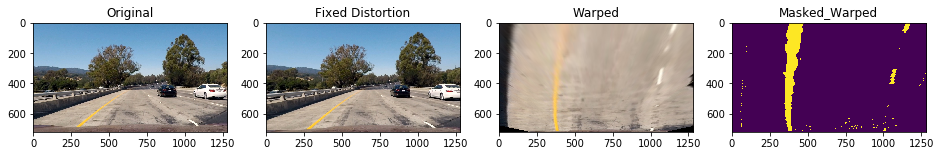

test2.jpg


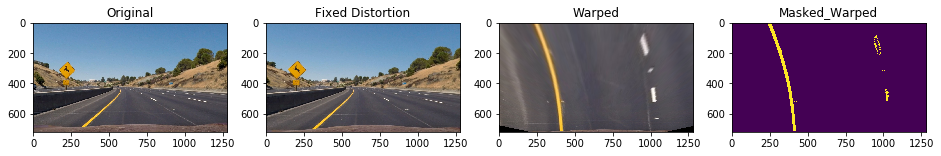

test3.jpg


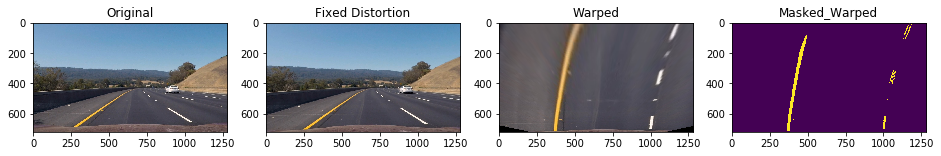

test4.jpg


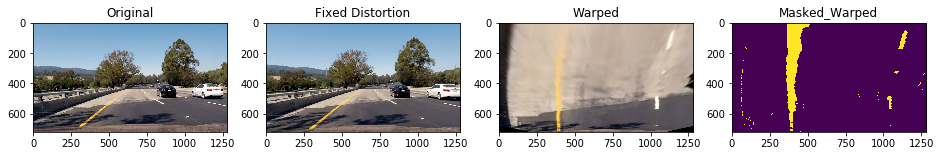

test5.jpg


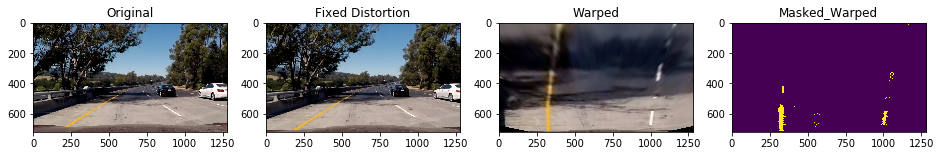

test6.jpg


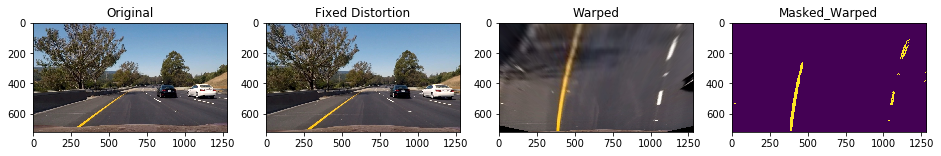

In [9]:
# plt.figure(figsize=(18,21))
for i, image in enumerate(test_images):
    img = read_img('test_images/' + image.strip())
    fixed_image = fix_distortion(img)
    warped_image = warp(fixed_image)[0]
    masked_warped = masking(warped_image)
    
    print(image)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.title('Original')
    plt.imshow(img)
    plt.subplot(142)
    plt.title('Fixed Distortion')
    plt.imshow(fixed_image)
    plt.subplot(143)
    plt.title('Warped')
    plt.imshow(warped_image)
    plt.subplot(144)
    plt.title('Masked_Warped')
    plt.imshow(masked_warped)
    plt.show()


(720, 1280)


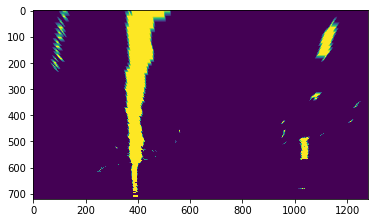

In [10]:
def pipeline(img):
    
#     img = read_img(img)
    
    img = fix_distortion(img)
    img = masking(img)
    img = roi(img, 'unwarped')
    img = warp(img)[0]
#     img = roi(img)

    
    return img
binary_warped = read_img('test_images/test4.jpg')
binary_warped = pipeline(binary_warped)
# binary_warped = pipeline('test_images/test5.jpg')
print (binary_warped.shape)
plt.imshow(binary_warped)
plt.show()

In [51]:
def blind_find_lane(image):
    
    # Create histogram of processed image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    
#     blanky = np.zeros_like(image)
    out_img = np.dstack((image, image, image))*255
    
    # Find midpoints, and peak points of left and right half of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
    
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    return leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, out_img

    
def draw_lane(left, right, color = 'green', linewidth = 3):
    
#     ploty = np.linspace(0, 719, num=720)
    
    plt.xlim(0, img.shape[1])
    plt.ylim(0, img.shape[0])
    
    plt.plot(left, ploty, color=color, linewidth=linewidth)
    plt.plot(right, ploty, color=color, linewidth=linewidth)
    plt.gca().invert_yaxis()
    
def fill_lane(image, left, right, l = True, r = True, color = 'green', linewidth = 3):
    
    # Create blank canvas
    zero_image = np.zeros_like(image).astype(np.uint8)
    zero_image = np.dstack((zero_image, zero_image, zero_image))
    
#     plt.plot(left, ploty, color=color, linewidth=linewidth)
#     plt.plot(right, ploty, color=color, linewidth=linewidth)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    
    pts_left = np.array([np.transpose(np.vstack([left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    if l == True:
        cv2.polylines(zero_image, np.int_([pts_left]), isClosed = False, color=(0,0,255), thickness = 40)
    else:
        cv2.polylines(zero_image, np.int_([pts_left]), isClosed = False, color=(255,0,0), thickness = 40)
    if r == True:
        cv2.polylines(zero_image, np.int_([pts_right]), isClosed = False, color=(0,0,255), thickness = 40)
    else:
        cv2.polylines(zero_image, np.int_([pts_right]), isClosed = False, color=(255,0,0), thickness = 40)
    
    cv2.fillPoly(zero_image, np.int_([pts]), (0, 255, 0))
    
    return zero_image
    
def unwarp(image, Minv):
    
    image = cv2.warpPerspective(image, Minv, (image.shape[1], image.shape[0]))
    
    return image

def combine_result(original, image):
    
    result = cv2.addWeighted(original, 1, image, 0.3, 0)
    
    return result
    
def add_results(image):
    

    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature:"
    cv2.putText(image, text, (50,50), font, 1, (255,255,255), 2)
    text = "How far from center"
    cv2.putText(image, text, (50,100), font, 1, (255,255,255), 2)
    
    return image

def fit_polynomial(poly, y, marg = 0):
    
    poly = np.asarray(poly)
    y = np.asarray(y)
    marg = np.asarray(marg)
    return ((poly[0] * y ** 2) + (poly[1] * y) + poly[2] + marg)

In [12]:
def calc_curvature(y, x):
    
    # Define y-value for location of curvature,  I chose middle y-value that corresponds
    # middle of the image
    y_eval = np.max(y) / 2
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit converted x,y values to polynomial
    fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
    
    # Calculate the curvature
    curverad = ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
    
#     print (curverad)
    
    return curverad

def find_center(left, right):
    
    left = left[0]*720**2 + left[1]*720 + left[2]
    right = right[0]*720**2 + right[1]*720 + right[2]
   
#     center = (1.5 * left - right) / 2
    center = 640 - ((right + left) / 2)
    
    xm_per_pix = 3.7/700 
    
    ret = center * xm_per_pix
    
    return ret


In [49]:
image = (read_img('test_images/test2.jpg'))

def total_process(img):
    


    
    original = img
    original = fix_distortion(original)
    
    ploty = np.linspace(0, original.shape[0]-1, original.shape[0] )
    
    processed = pipeline(img)
    
    leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, out_img = blind_find_lane(processed)

    plt.imshow(out_img)
    plt.show()
    left_int_top = fit_polynomial(left_fit, 0)
    right_int_top = fit_polynomial(right_fit, 0)
    left_int_bot = fit_polynomial(left_fit, 720)
    right_int_bot = fit_polynomial(right_fit, 720)
    print (left_fit, right_fit)
    print (left_int_top, right_int_top, left_int_bot, right_int_bot)
#     print (left_fitx)
    
    filled_image = fill_lane(processed, left_fitx, right_fitx)    
    
    unwarped = unwarp(filled_image, Minv)
    
    result = combine_result(original, unwarped)
    
    curvature_left = calc_curvature(ploty, left_fitx)
    curvature_right = calc_curvature(ploty, right_fitx)
    
    center = find_center(left_fit, right_fit)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    text = "Radius of Left Curvature: {:.2f}".format(curvature_left)
    cv2.putText(result, text, (50,50), font, 1, (255,255,255), 2)
    text = "Radius of Right Curvature: {:.2f}".format(curvature_right)
    cv2.putText(result, text, (50,100), font, 1, (255,255,255), 2)
    if center < 0:
        text = "{:.2f} left of center".format(abs(center))
    else:
        text = "{:.2f} right of center".format(abs(center))
    cv2.putText(result, text, (50,150), font, 1, (255,255,255), 2)
    
    
    return result
    

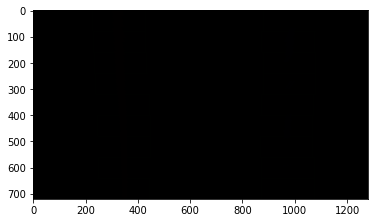

[ -2.08963405e-05   5.91429624e-02   3.21025073e+02] [  5.34613004e-05  -6.19627414e-02   9.88588693e+02]
321.025073424 988.588693103 352.77534346 971.689857386


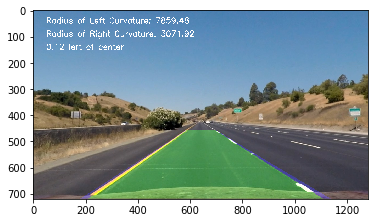

In [50]:
image = read_img('test_images/straight_lines1.jpg')
plt.imshow(total_process(image))
plt.show()

In [40]:
from collections import deque

class Line():
    
    def __init__(self, side):
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # Set which side the Line object is
        self.side = side
        
        # Count how many values in history list
        self.history = 0
        
        # Last value of lane in previous frame
        self.recent_x = deque(maxlen = 10)
        
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen = 10) 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = None#[]#[np.array([False])]  
        
        self.current_x = None#[]#[np.array([False])]
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
        self.int_top = deque(maxlen = 10)
        
        self.int_bot = deque(maxlen = 10)
        
        self.best_top = None
        
        self.best_bot = None
        

        
#         #x values for detected line pixels
#         self.allx = None  
        
#         #y values for detected line pixels
#         self.ally = None
        
        # Keep number of frames
        self.count = 0
        
    def blind_find_lane(self, image):
        
        side = self.side
        
        out_img = np.dstack((image, image, image))*255

        # Create histogram of processed image
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)

        # Find midpoints, and peak points of left and right half of the histogram
        midpoint = np.int(histogram.shape[0]/2)
        
        if self.side == 'left':
            x_base = np.argmax(histogram[:midpoint])
        elif self.side == 'right':
            x_base = np.argmax(histogram[:midpoint]) + midpoint
        else:
            raise ValueError

        # Choose the number of sliding windows
        nwindows = 9

        # Set height of windows
        window_height = np.int(image.shape[0]/nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        x_current = x_base

        # Set the width of the windows +/- margin
        margin = 100

        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive lane pixel indices
        lane_inds = []

        for window in range(nwindows):

            # Identify window boundaries in x and y (and right and left)
            win_y_low = image.shape[0] - (window+1)*window_height
            win_y_high = image.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_x_low, win_y_low), (win_x_high, win_y_high), (0,255,0), 2)

            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)
#         print (self.side, len(lane_inds))

        # Extract line pixel positions
        x = nonzerox[lane_inds]
#         print (self.side, len(x))

        y = nonzeroy[lane_inds]
    
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        
    
        if len(x) < 25:
            fit = None
            fitx = None
            trigger = True
        
        else:

            # Fit a second order polynomial
            fit = np.polyfit(y, x, 2)
            fitx = self.fit_polynomial(fit, ploty)
            trigger = False

        return fit, fitx, out_img, trigger

    def exp_find_lane(self, image, fit):
        
#         side = self.side
        
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        lane_inds = ((nonzerox > self.fit_polynomial(fit, nonzeroy, marg = -margin)) & (nonzerox < self.fit_polynomial(fit, nonzeroy, marg = margin)))

        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]

        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        
        if len(x) < 25:
            fit = None
            fitx = None
            trigger = True
            
        else:
        
            # Fit a second order polynomial to each
            fit = np.polyfit(y, x, 2)
            fitx = self.fit_polynomial(fit, ploty)
            trigger = False

        out_img = fill_lane(image, fitx-margin, fitx+margin)
        
        return fit, fitx, out_img, trigger
    
    def fit_polynomial(self, poly, y, marg = 0):
        poly = np.asarray(poly)
        y = np.asarray(y)
        marg = np.asarray(marg)
        return ((poly[0] * y ** 2) + (poly[1] * y) + poly[2] + marg)
    
    def calc_curvature(self, y, x):
    
        # Define y-value for location of curvature,  I chose middle y-value that corresponds
        # middle of the image
        y_eval = np.max(y) / 2

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit converted x,y values to polynomial
        fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)

        # Calculate the curvature
        curverad = ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])

    #     print (curverad)

        return curverad

    def find_center(self, left, right):

        left = left[0]*720**2 + left[1]*720 + left[2]
        right = right[0]*720**2 + right[1]*720 + right[2]

    #     center = (1.5 * left - right) / 2
        center = 640 - ((right + left) / 2)

        xm_per_pix = 3.7/700 

        ret = center * xm_per_pix

        return ret

    
def sanity_check(left_fitx, right_fitx):
    
    left_lane_status = False
    right_lane_status = False
    
    if (((max(abs(right_fitx))-max(abs(left_fitx))) > 600) & ((max(abs(right_fitx)) - max(abs(left_fitx))) < 800)):
        if (((min(abs(right_fitx))-min(abs(left_fitx))) > 600) & ((min(abs(right_fitx))-min(abs(left_fitx))) < 800)):
#             print('lane wide enough')
#         left_lane_status = True
#         right_lane_status = True
    
            if (max(abs(left_fitx)) - min(abs(left_fitx))) < 300:
#                 print('left lane seems ok')
                left_lane_status = True
            if (max(abs(right_fitx)) - min(abs(right_fitx))) < 300:
#                 print('right lane seems ok')
                right_lane_status = True
            
    return left_lane_status, right_lane_status
            

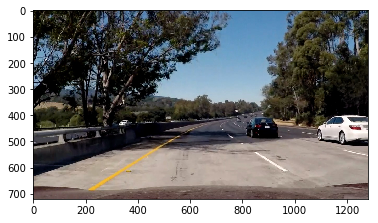

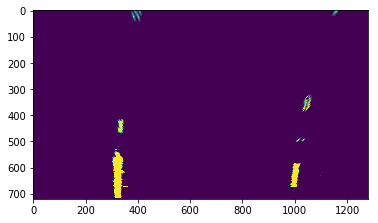

True
True


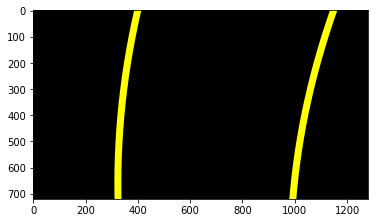

In [36]:
left = Line('left')
right = Line('right')
image = (read_img('test_images/test5.jpg'))
plt.imshow(image)
plt.show()
ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
image = pipeline(image)
plt.imshow(image)
plt.show()
left_fit, left_fitx, left_img, left_trigger = left.blind_find_lane(image)
right_fit, right_fitx, right_img, right_trigger = right.blind_find_lane(image)
l, r = sanity_check(left_fitx, right_fitx)
print (l)
print (r)
# print((left_fitx[719]))
mixed_img = cv2.addWeighted(left_img, 1, right_img, 1, 0)
# mixed_img = combine_result(left_img, right_img)
plt.imshow(mixed_img)
plt.plot(left_fitx, ploty, color='yellow', linewidth=7)
plt.plot(right_fitx, ploty, color='yellow', linewidth=7)
plt.show()

In [32]:
# left = Line('left')
# right = Line('right')

def final_process(img):
    


    
    original = img
    original = fix_distortion(original)
    
    ploty = np.linspace(0, original.shape[0]-1, original.shape[0] )
    
    processed = pipeline(img)
    
    if left.detected == False:
        left_fit, left_fitx, left_img, left_trigger = left.blind_find_lane(processed)
    else:
        left_fit, left_fitx, left_img, left_trigger = left.exp_find_lane(processed, left.current_fit)
        
    if right.detected == False:
        right_fit, right_fitx, right_img, right_trigger = right.blind_find_lane(processed)
    else:
        right_fit, right_fitx, right_img, right_trigger = right.exp_find_lane(processed, right.current_fit)

#     if left_trigger is True and right_trigger is True:
#         l, r = sanity_check(left_fitx, right_fitx)
#     else:
#         l, r = False, False
    
#     if ((left_trigger == True) & (l == True)):
#         l = True
#     else:
#         l = False
        
#     if ((right_trigger == True) & (r == True)):
#         r = True
#     else:
#         r = False
    
#     print (len(left_fitx))
    if left_trigger == True:
        left.detected = True
        
        if left.history > 0:
            left.best_top = 

        left_int_top = left.fit_polynomial(left_fit, 0)
        left_int_bot = left.fit_polynomial(left_fit, 720)
        
        left.recent_x.append(left_fitx)
        left.recent_xfitted.append(left_fit)
        left.int_top.append(left.fit_polynomial(left_fit, 0))
        left.int_bot.append(left.fit_polynomial(left_fit, 720))
        left.history = len(left.recent_x)
        left.bestx = np.mean(left.recent_x, axis=0)
        left.best_fit = np.mean(left.recent_xfitted, axis=0)
        left.best_top = np.mean(left.int_top, axis=0)
        left.best_bot = np.mean(left.int_bot, axis=0)
        if left.history > 0:
            left.current_fit = left.best_fit
            left.current_x = left.bestx
        
    else:
        left.detected = False
        if left.history > 0:
            left.current_fit = left.best_fit
            left.current_x = left.bestx
        else:
            left.current_fit = left_fit
            left.current_x = left_fitx
        
    
    if r == True:
        right.detected = True
        right.current_fit = right_fit
        right.current_x = right_fitx
        
#         if right.history > 0:
#             right.diffs = right_fit - right.best_fit
#         else:
#             right.diffs = right_fit
        
        right.recent_x.append(right_fitx)
        right.recent_xfitted.append(right_fit)
        right.history = len(right.recent_x)
        right.bestx = np.mean(right.recent_x, axis=0)
        right.best_fit = np.mean(right.recent_xfitted, axis=0)
    else:
        right.detected = False
        if right.history > 0:
            right.current_fit = right.best_fit
            right.current_x = right.bestx
        else:
            right.current_fit = right_fit
            right.current_x = right_fitx

    left.count += 1
    right.count += 1
    print (len(left.current_x), left.history)
    print (len(right.current_x), right.history)
    
    filled_image = fill_lane(processed, left.current_x, right.current_x, l, r)    
    
    unwarped = unwarp(filled_image, Minv)
    
    result = combine_result(original, unwarped)
    
    curvature_left = calc_curvature(ploty, left.current_x)
    curvature_right = calc_curvature(ploty, right.current_x)
    
    center = find_center(left.current_fit, right.current_fit)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    text = "Radius of Left Curvature: {:.2f} m".format(curvature_left)
    cv2.putText(result, text, (50,50), font, 1, (255,255,255), 2)
    text = "Radius of Right Curvature: {:.2f} m".format(curvature_right)
    cv2.putText(result, text, (50,100), font, 1, (255,255,255), 2)
    if center < 0:
        text = "{:.2f} m left of center".format(abs(center))
    else:
        text = "{:.2f} m right of center".format(abs(center))
    cv2.putText(result, text, (50,150), font, 1, (255,255,255), 2)
    if left.detected == False:
        text = "Left lane: Lost"
        cv2.putText(result, text, (50,200), font, 1, (255,0,0), 2)
    else:
        text = "Left lane: Found"
        cv2.putText(result, text, (50,200), font, 1, (0,255,0), 2)
    
    if right.detected == False:
        text = "Right lane: Lost"
        cv2.putText(result, text, (50,250), font, 1, (255,0,0), 2)
    else:
        text = "Right lane: Found"
        cv2.putText(result, text, (50,250), font, 1, (0,255,0), 2)
    text = "Frame: {}".format(left.count)
    cv2.putText(result, text, (1000,50), font, 1, (255,255,255), 2)
    
    
    return result

720 0
720 0


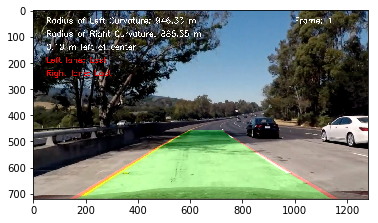

In [37]:
left = Line('left')
right = Line('right')
image = (read_img('test_images/test5.jpg'))
# plt.figure(figsize=(16,10))
plt.imshow(final_process(image))
plt.show()

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
left = Line('left')
right = Line('right')

output = 'test5.mp4'
clip1 = VideoFileClip('project_video.mp4')
output_clip = clip1.fl_image(final_process)
%time output_clip.write_videofile(output, audio=False)

720 0
720 0
[MoviePy] >>>> Building video test5.mp4
[MoviePy] Writing video test5.mp4



  0%|                                                                                       | 0/1261 [00:00<?, ?it/s]

720 0
720 0



  0%|                                                                               | 1/1261 [00:00<06:42,  3.13it/s]

720 0
720 0



  0%|▏                                                                              | 2/1261 [00:00<06:44,  3.12it/s]

720 0
720 0



  0%|▏                                                                              | 3/1261 [00:00<06:38,  3.16it/s]

720 0
720 0



  0%|▎                                                                              | 4/1261 [00:01<06:41,  3.13it/s]

720 0
720 0



  0%|▎                                                                              | 5/1261 [00:01<06:38,  3.15it/s]

720 0
720 0



  0%|▍                                                                              | 6/1261 [00:01<06:43,  3.11it/s]

720 0
720 0



  1%|▍                                                                              | 7/1261 [00:02<06:35,  3.17it/s]

720 0
720 0



  1%|▌                                                                              | 8/1261 [00:02<06:30,  3.21it/s]

720 0
720 0



  1%|▌                                                                              | 9/1261 [00:02<06:29,  3.22it/s]

720 0
720 0



  1%|▌                                                                             | 10/1261 [00:03<06:25,  3.25it/s]

720 0
720 0



  1%|▋                                                                             | 11/1261 [00:03<06:21,  3.28it/s]

720 0
720 0



  1%|▋                                                                             | 12/1261 [00:03<06:27,  3.23it/s]

720 0
720 0



  1%|▊                                                                             | 13/1261 [00:04<06:33,  3.17it/s]

720 0
720 0



  1%|▊                                                                             | 14/1261 [00:04<06:32,  3.17it/s]

720 0
720 0



  1%|▉                                                                             | 15/1261 [00:04<06:37,  3.14it/s]

720 0
720 0



  1%|▉                                                                             | 16/1261 [00:05<06:37,  3.13it/s]

720 0
720 0



  1%|█                                                                             | 17/1261 [00:05<06:31,  3.18it/s]

720 0
720 0



  1%|█                                                                             | 18/1261 [00:05<06:28,  3.20it/s]

720 0
720 0



  2%|█▏                                                                            | 19/1261 [00:05<06:25,  3.23it/s]

720 0
720 0



  2%|█▏                                                                            | 20/1261 [00:06<06:26,  3.21it/s]

720 0
720 0



  2%|█▎                                                                            | 21/1261 [00:06<06:27,  3.20it/s]

720 0
720 0



  2%|█▎                                                                            | 22/1261 [00:06<06:31,  3.16it/s]

720 0
720 0



  2%|█▍                                                                            | 23/1261 [00:07<06:27,  3.19it/s]

720 0
720 0



  2%|█▍                                                                            | 24/1261 [00:07<06:27,  3.19it/s]

720 0
720 0



  2%|█▌                                                                            | 25/1261 [00:07<06:24,  3.21it/s]

720 0
720 0



  2%|█▌                                                                            | 26/1261 [00:08<06:25,  3.20it/s]

720 0
720 0



  2%|█▋                                                                            | 27/1261 [00:08<06:22,  3.22it/s]

720 0
720 0



  2%|█▋                                                                            | 28/1261 [00:08<06:23,  3.21it/s]

720 0
720 0



  2%|█▊                                                                            | 29/1261 [00:09<06:27,  3.18it/s]

720 0
720 0



  2%|█▊                                                                            | 30/1261 [00:09<06:28,  3.17it/s]

720 0
720 0



  2%|█▉                                                                            | 31/1261 [00:09<06:34,  3.11it/s]

720 0
720 0



  3%|█▉                                                                            | 32/1261 [00:10<06:31,  3.14it/s]

720 0
720 0



  3%|██                                                                            | 33/1261 [00:10<06:24,  3.20it/s]

720 0
720 0



  3%|██                                                                            | 34/1261 [00:10<06:24,  3.19it/s]

720 0
720 0



  3%|██▏                                                                           | 35/1261 [00:10<06:26,  3.17it/s]

720 0
720 0



  3%|██▏                                                                           | 36/1261 [00:11<06:31,  3.13it/s]

720 0
720 0



  3%|██▎                                                                           | 37/1261 [00:11<06:30,  3.14it/s]

720 0
720 0



  3%|██▎                                                                           | 38/1261 [00:11<06:28,  3.14it/s]

720 0
720 0



  3%|██▍                                                                           | 39/1261 [00:12<06:30,  3.13it/s]

720 0
720 0



  3%|██▍                                                                           | 40/1261 [00:12<06:23,  3.18it/s]

720 0
720 0



  3%|██▌                                                                           | 41/1261 [00:12<06:24,  3.18it/s]

720 0
720 0



  3%|██▌                                                                           | 42/1261 [00:13<06:25,  3.16it/s]

720 0
720 0



  3%|██▋                                                                           | 43/1261 [00:13<06:28,  3.13it/s]

720 0
720 0



  3%|██▋                                                                           | 44/1261 [00:13<06:24,  3.17it/s]

720 0
720 0



  4%|██▊                                                                           | 45/1261 [00:14<06:28,  3.13it/s]

720 0
720 0



  4%|██▊                                                                           | 46/1261 [00:14<06:24,  3.16it/s]

720 0
720 0



  4%|██▉                                                                           | 47/1261 [00:14<06:25,  3.15it/s]

720 0
720 0



  4%|██▉                                                                           | 48/1261 [00:15<06:29,  3.12it/s]

720 0
720 0



  4%|███                                                                           | 49/1261 [00:15<06:22,  3.17it/s]

720 0
720 0



  4%|███                                                                           | 50/1261 [00:15<06:22,  3.16it/s]

720 0
720 0



  4%|███▏                                                                          | 51/1261 [00:16<06:22,  3.16it/s]

720 0
720 0



  4%|███▏                                                                          | 52/1261 [00:16<06:27,  3.12it/s]

720 0
720 0



  4%|███▎                                                                          | 53/1261 [00:16<06:26,  3.13it/s]

720 0
720 0



  4%|███▎                                                                          | 54/1261 [00:17<06:25,  3.13it/s]

720 0
720 0



  4%|███▍                                                                          | 55/1261 [00:17<06:20,  3.17it/s]

720 0
720 0



  4%|███▍                                                                          | 56/1261 [00:17<06:18,  3.18it/s]

720 0
720 0



  5%|███▌                                                                          | 57/1261 [00:17<06:18,  3.18it/s]

720 0
720 0



  5%|███▌                                                                          | 58/1261 [00:18<06:21,  3.15it/s]

720 0
720 0



  5%|███▋                                                                          | 59/1261 [00:18<06:25,  3.12it/s]

720 0
720 0



  5%|███▋                                                                          | 60/1261 [00:18<06:24,  3.12it/s]

720 0
720 0



  5%|███▊                                                                          | 61/1261 [00:19<06:21,  3.15it/s]

720 0
720 0



  5%|███▊                                                                          | 62/1261 [00:19<06:22,  3.14it/s]

720 0
720 0



  5%|███▉                                                                          | 63/1261 [00:19<06:26,  3.10it/s]

720 0
720 0



  5%|███▉                                                                          | 64/1261 [00:20<06:20,  3.15it/s]

720 0
720 0



  5%|████                                                                          | 65/1261 [00:20<06:17,  3.17it/s]

720 0
720 0



  5%|████                                                                          | 66/1261 [00:20<06:19,  3.15it/s]

720 0
720 0



  5%|████▏                                                                         | 67/1261 [00:21<06:29,  3.07it/s]

720 0
720 0



  5%|████▏                                                                         | 68/1261 [00:21<06:29,  3.06it/s]

720 0
720 0



  5%|████▎                                                                         | 69/1261 [00:21<06:26,  3.08it/s]

720 0
720 0



  6%|████▎                                                                         | 70/1261 [00:22<06:20,  3.13it/s]

720 0
720 0



  6%|████▍                                                                         | 71/1261 [00:22<06:17,  3.15it/s]

720 0
720 0



  6%|████▍                                                                         | 72/1261 [00:22<06:20,  3.12it/s]

720 0
720 0



  6%|████▌                                                                         | 73/1261 [00:23<06:15,  3.16it/s]

720 0
720 0



  6%|████▌                                                                         | 74/1261 [00:23<06:16,  3.15it/s]

720 0
720 0



  6%|████▋                                                                         | 75/1261 [00:23<06:22,  3.10it/s]

720 0
720 0



  6%|████▋                                                                         | 76/1261 [00:24<06:22,  3.09it/s]

720 0
720 0



  6%|████▊                                                                         | 77/1261 [00:24<06:19,  3.12it/s]

720 0
720 0



  6%|████▊                                                                         | 78/1261 [00:24<06:22,  3.09it/s]

720 0
720 0



  6%|████▉                                                                         | 79/1261 [00:25<06:13,  3.17it/s]

720 0
720 0



  6%|████▉                                                                         | 80/1261 [00:25<06:11,  3.18it/s]

720 0
720 0



  6%|█████                                                                         | 81/1261 [00:25<06:12,  3.17it/s]

720 0
720 0



  7%|█████                                                                         | 82/1261 [00:25<06:15,  3.14it/s]

720 0
720 0



  7%|█████▏                                                                        | 83/1261 [00:26<06:17,  3.12it/s]

720 0
720 0



  7%|█████▏                                                                        | 84/1261 [00:26<06:14,  3.14it/s]

720 0
720 0



  7%|█████▎                                                                        | 85/1261 [00:26<06:13,  3.15it/s]

720 0
720 0



  7%|█████▎                                                                        | 86/1261 [00:27<06:08,  3.19it/s]

720 0
720 0



  7%|█████▍                                                                        | 87/1261 [00:27<06:13,  3.14it/s]

720 0
720 0



  7%|█████▍                                                                        | 88/1261 [00:27<06:10,  3.16it/s]

720 0
720 0



  7%|█████▌                                                                        | 89/1261 [00:28<06:11,  3.16it/s]

720 0
720 0



  7%|█████▌                                                                        | 90/1261 [00:28<06:17,  3.11it/s]

720 0
720 0



  7%|█████▋                                                                        | 91/1261 [00:28<06:14,  3.13it/s]

720 0
720 0



  7%|█████▋                                                                        | 92/1261 [00:29<06:10,  3.15it/s]

720 0
720 0



  7%|█████▊                                                                        | 93/1261 [00:29<06:10,  3.15it/s]

720 0
720 0



  7%|█████▊                                                                        | 94/1261 [00:29<06:12,  3.13it/s]

720 0
720 0



  8%|█████▉                                                                        | 95/1261 [00:30<06:04,  3.20it/s]

720 0
720 0



  8%|█████▉                                                                        | 96/1261 [00:30<06:02,  3.22it/s]

720 0
720 0



  8%|██████                                                                        | 97/1261 [00:30<06:04,  3.19it/s]

720 0
720 0



  8%|██████                                                                        | 98/1261 [00:31<06:03,  3.20it/s]

720 0
720 0



  8%|██████                                                                        | 99/1261 [00:31<06:04,  3.19it/s]

720 0
720 0



  8%|██████                                                                       | 100/1261 [00:31<06:05,  3.17it/s]

720 0
720 0



  8%|██████▏                                                                      | 101/1261 [00:31<06:03,  3.19it/s]

720 0
720 0



  8%|██████▏                                                                      | 102/1261 [00:32<06:08,  3.15it/s]

720 0
720 0



  8%|██████▎                                                                      | 103/1261 [00:32<06:11,  3.12it/s]

720 0
720 0



  8%|██████▎                                                                      | 104/1261 [00:32<06:11,  3.11it/s]

720 0
720 0



  8%|██████▍                                                                      | 105/1261 [00:33<06:11,  3.11it/s]

720 0
720 0



  8%|██████▍                                                                      | 106/1261 [00:33<06:12,  3.10it/s]

720 0
720 0



  8%|██████▌                                                                      | 107/1261 [00:33<06:17,  3.05it/s]

720 0
720 0



  9%|██████▌                                                                      | 108/1261 [00:34<06:13,  3.09it/s]

720 0
720 0



  9%|██████▋                                                                      | 109/1261 [00:34<06:07,  3.13it/s]

720 0
720 0



  9%|██████▋                                                                      | 110/1261 [00:34<06:04,  3.16it/s]

720 0
720 0



  9%|██████▊                                                                      | 111/1261 [00:35<06:04,  3.15it/s]

720 0
720 0



  9%|██████▊                                                                      | 112/1261 [00:35<06:05,  3.15it/s]

720 0
720 0



  9%|██████▉                                                                      | 113/1261 [00:35<06:05,  3.14it/s]

720 0
720 0



  9%|██████▉                                                                      | 114/1261 [00:36<06:08,  3.11it/s]

720 0
720 0



  9%|███████                                                                      | 115/1261 [00:36<06:08,  3.11it/s]

720 0
720 0



  9%|███████                                                                      | 116/1261 [00:36<06:08,  3.11it/s]

720 0
720 0



  9%|███████▏                                                                     | 117/1261 [00:37<06:14,  3.06it/s]

720 0
720 0



  9%|███████▏                                                                     | 118/1261 [00:37<06:06,  3.12it/s]

720 0
720 0



  9%|███████▎                                                                     | 119/1261 [00:37<06:07,  3.10it/s]

720 0
720 0



 10%|███████▎                                                                     | 120/1261 [00:38<06:05,  3.12it/s]

720 0
720 0



 10%|███████▍                                                                     | 121/1261 [00:38<06:02,  3.15it/s]

720 0
720 0



 10%|███████▍                                                                     | 122/1261 [00:38<06:00,  3.16it/s]

720 0
720 0



 10%|███████▌                                                                     | 123/1261 [00:39<06:00,  3.16it/s]

720 0
720 0



 10%|███████▌                                                                     | 124/1261 [00:39<06:05,  3.11it/s]

720 0
720 0



 10%|███████▋                                                                     | 125/1261 [00:39<06:02,  3.13it/s]

720 0
720 0



 10%|███████▋                                                                     | 126/1261 [00:39<05:58,  3.17it/s]

720 0
720 0



 10%|███████▊                                                                     | 127/1261 [00:40<05:56,  3.18it/s]

720 0
720 0



 10%|███████▊                                                                     | 128/1261 [00:40<05:57,  3.17it/s]

720 0
720 0



 10%|███████▉                                                                     | 129/1261 [00:40<06:01,  3.13it/s]

720 0
720 0



 10%|███████▉                                                                     | 130/1261 [00:41<06:05,  3.09it/s]

720 0
720 0



 10%|███████▉                                                                     | 131/1261 [00:41<06:05,  3.09it/s]

720 0
720 0



 10%|████████                                                                     | 132/1261 [00:41<06:04,  3.10it/s]

720 0
720 0



 11%|████████                                                                     | 133/1261 [00:42<05:56,  3.16it/s]

720 0
720 0



 11%|████████▏                                                                    | 134/1261 [00:42<05:58,  3.15it/s]

720 0
720 0



 11%|████████▏                                                                    | 135/1261 [00:42<05:59,  3.13it/s]

720 0
720 0



 11%|████████▎                                                                    | 136/1261 [00:43<05:53,  3.18it/s]

720 0
720 0



 11%|████████▎                                                                    | 137/1261 [00:43<05:55,  3.17it/s]

720 0
720 0



 11%|████████▍                                                                    | 138/1261 [00:43<05:55,  3.16it/s]

720 0
720 0



 11%|████████▍                                                                    | 139/1261 [00:44<05:56,  3.15it/s]

720 0
720 0



 11%|████████▌                                                                    | 140/1261 [00:44<05:59,  3.12it/s]

720 0
720 0



 11%|████████▌                                                                    | 141/1261 [00:44<05:59,  3.11it/s]

720 0
720 0



 11%|████████▋                                                                    | 142/1261 [00:45<05:58,  3.12it/s]

720 0
720 0



 11%|████████▋                                                                    | 143/1261 [00:45<05:59,  3.11it/s]

720 0
720 0



 11%|████████▊                                                                    | 144/1261 [00:45<05:56,  3.14it/s]

720 0
720 0



 11%|████████▊                                                                    | 145/1261 [00:46<05:55,  3.14it/s]

720 0
720 0



 12%|████████▉                                                                    | 146/1261 [00:46<05:51,  3.17it/s]

720 0
720 0



 12%|████████▉                                                                    | 147/1261 [00:46<05:49,  3.18it/s]

720 0
720 0



 12%|█████████                                                                    | 148/1261 [00:46<05:55,  3.13it/s]

720 0
720 0



 12%|█████████                                                                    | 149/1261 [00:47<05:55,  3.13it/s]

720 0
720 0



 12%|█████████▏                                                                   | 150/1261 [00:47<05:54,  3.14it/s]

720 0
720 0



 12%|█████████▏                                                                   | 151/1261 [00:47<05:54,  3.13it/s]

720 0
720 0



 12%|█████████▎                                                                   | 152/1261 [00:48<05:53,  3.14it/s]

720 0
720 0



 12%|█████████▎                                                                   | 153/1261 [00:48<05:52,  3.14it/s]

720 0
720 0



 12%|█████████▍                                                                   | 154/1261 [00:48<05:51,  3.15it/s]

720 0
720 0



 12%|█████████▍                                                                   | 155/1261 [00:49<05:50,  3.15it/s]

720 0
720 0



 12%|█████████▌                                                                   | 156/1261 [00:49<05:51,  3.14it/s]

720 0
720 0



 12%|█████████▌                                                                   | 157/1261 [00:49<05:51,  3.14it/s]

720 0
720 0



 13%|█████████▋                                                                   | 158/1261 [00:50<05:52,  3.13it/s]

720 0
720 0



 13%|█████████▋                                                                   | 159/1261 [00:50<05:48,  3.17it/s]

720 0
720 0



 13%|█████████▊                                                                   | 160/1261 [00:50<05:49,  3.15it/s]

720 0
720 0



 13%|█████████▊                                                                   | 161/1261 [00:51<05:51,  3.13it/s]

720 0
720 0



 13%|█████████▉                                                                   | 162/1261 [00:51<05:59,  3.06it/s]

720 0
720 0



 13%|█████████▉                                                                   | 163/1261 [00:51<05:55,  3.09it/s]

720 0
720 0



 13%|██████████                                                                   | 164/1261 [00:52<05:52,  3.11it/s]

720 0
720 0



 13%|██████████                                                                   | 165/1261 [00:52<05:50,  3.13it/s]

720 0
720 0



 13%|██████████▏                                                                  | 166/1261 [00:52<05:48,  3.14it/s]

720 0
720 0



 13%|██████████▏                                                                  | 167/1261 [00:53<05:49,  3.13it/s]

720 0
720 0



 13%|██████████▎                                                                  | 168/1261 [00:53<05:47,  3.14it/s]

720 0
720 0



 13%|██████████▎                                                                  | 169/1261 [00:53<05:48,  3.14it/s]

720 0
720 0



 13%|██████████▍                                                                  | 170/1261 [00:54<05:46,  3.15it/s]

720 0
720 0



 14%|██████████▍                                                                  | 171/1261 [00:54<05:44,  3.16it/s]

720 0
720 0



 14%|██████████▌                                                                  | 172/1261 [00:54<05:45,  3.15it/s]

720 0
720 0



 14%|██████████▌                                                                  | 173/1261 [00:54<05:42,  3.18it/s]

720 0
720 0



 14%|██████████▌                                                                  | 174/1261 [00:55<05:40,  3.20it/s]

720 0
720 0



 14%|██████████▋                                                                  | 175/1261 [00:55<05:37,  3.21it/s]

720 0
720 0



 14%|██████████▋                                                                  | 176/1261 [00:55<05:43,  3.16it/s]

720 0
720 0



 14%|██████████▊                                                                  | 177/1261 [00:56<05:41,  3.18it/s]

720 0
720 0



 14%|██████████▊                                                                  | 178/1261 [00:56<05:42,  3.16it/s]

720 0
720 0



 14%|██████████▉                                                                  | 179/1261 [00:56<05:49,  3.10it/s]

720 0
720 0



 14%|██████████▉                                                                  | 180/1261 [00:57<05:53,  3.05it/s]

720 0
720 0



 14%|███████████                                                                  | 181/1261 [00:57<05:51,  3.08it/s]

720 0
720 0



 14%|███████████                                                                  | 182/1261 [00:57<05:50,  3.08it/s]

720 0
720 0



 15%|███████████▏                                                                 | 183/1261 [00:58<05:50,  3.07it/s]

720 0
720 0



 15%|███████████▏                                                                 | 184/1261 [00:58<05:50,  3.07it/s]

720 0
720 0



 15%|███████████▎                                                                 | 185/1261 [00:58<05:47,  3.10it/s]

720 0
720 0



 15%|███████████▎                                                                 | 186/1261 [00:59<05:46,  3.10it/s]

720 0
720 0



 15%|███████████▍                                                                 | 187/1261 [00:59<05:47,  3.09it/s]

720 0
720 0



 15%|███████████▍                                                                 | 188/1261 [00:59<05:43,  3.12it/s]

720 0
720 0



 15%|███████████▌                                                                 | 189/1261 [01:00<05:43,  3.12it/s]

720 0
720 0



 15%|███████████▌                                                                 | 190/1261 [01:00<05:44,  3.11it/s]

720 0
720 0



 15%|███████████▋                                                                 | 191/1261 [01:00<05:43,  3.12it/s]

720 0
720 0



 15%|███████████▋                                                                 | 192/1261 [01:01<05:48,  3.07it/s]

720 0
720 0



 15%|███████████▊                                                                 | 193/1261 [01:01<05:48,  3.07it/s]

720 0
720 0



 15%|███████████▊                                                                 | 194/1261 [01:01<05:50,  3.05it/s]

720 0
720 0



 15%|███████████▉                                                                 | 195/1261 [01:02<05:47,  3.06it/s]

720 0
720 0



 16%|███████████▉                                                                 | 196/1261 [01:02<05:39,  3.14it/s]

720 0
720 0



 16%|████████████                                                                 | 197/1261 [01:02<05:39,  3.14it/s]

720 0
720 0



 16%|████████████                                                                 | 198/1261 [01:03<05:38,  3.14it/s]

720 0
720 0



 16%|████████████▏                                                                | 199/1261 [01:03<05:44,  3.09it/s]

720 0
720 0



 16%|████████████▏                                                                | 200/1261 [01:03<05:49,  3.04it/s]

720 0
720 0



 16%|████████████▎                                                                | 201/1261 [01:03<05:42,  3.09it/s]

720 0
720 0



 16%|████████████▎                                                                | 202/1261 [01:04<05:40,  3.11it/s]

720 0
720 0



 16%|████████████▍                                                                | 203/1261 [01:04<05:44,  3.07it/s]

720 0
720 0



 16%|████████████▍                                                                | 204/1261 [01:04<05:39,  3.12it/s]

720 0
720 0



 16%|████████████▌                                                                | 205/1261 [01:05<05:42,  3.08it/s]

720 0
720 0



 16%|████████████▌                                                                | 206/1261 [01:05<05:48,  3.03it/s]

720 0
720 0



 16%|████████████▋                                                                | 207/1261 [01:05<05:45,  3.05it/s]

720 0
720 0



 16%|████████████▋                                                                | 208/1261 [01:06<05:44,  3.06it/s]

720 0
720 0



 17%|████████████▊                                                                | 209/1261 [01:06<05:40,  3.09it/s]

720 0
720 0



 17%|████████████▊                                                                | 210/1261 [01:06<05:38,  3.11it/s]

720 0
720 0



 17%|████████████▉                                                                | 211/1261 [01:07<05:31,  3.17it/s]

720 0
720 0



 17%|████████████▉                                                                | 212/1261 [01:07<05:33,  3.15it/s]

720 0
720 0



 17%|█████████████                                                                | 213/1261 [01:07<05:34,  3.13it/s]

720 0
720 0



 17%|█████████████                                                                | 214/1261 [01:08<05:31,  3.16it/s]

720 0
720 0



 17%|█████████████▏                                                               | 215/1261 [01:08<05:32,  3.15it/s]

720 0
720 0



 17%|█████████████▏                                                               | 216/1261 [01:08<05:29,  3.17it/s]

720 0
720 0



 17%|█████████████▎                                                               | 217/1261 [01:09<05:30,  3.16it/s]

720 0
720 0



 17%|█████████████▎                                                               | 218/1261 [01:09<05:28,  3.18it/s]

720 0
720 0



 17%|█████████████▎                                                               | 219/1261 [01:09<05:35,  3.10it/s]

720 0
720 0



 17%|█████████████▍                                                               | 220/1261 [01:10<05:37,  3.09it/s]

720 0
720 0



 18%|█████████████▍                                                               | 221/1261 [01:10<05:36,  3.09it/s]

720 0
720 0



 18%|█████████████▌                                                               | 222/1261 [01:10<05:33,  3.11it/s]

720 0
720 0



 18%|█████████████▌                                                               | 223/1261 [01:11<05:29,  3.15it/s]

720 0
720 0



 18%|█████████████▋                                                               | 224/1261 [01:11<05:33,  3.11it/s]

720 0
720 0



 18%|█████████████▋                                                               | 225/1261 [01:11<05:34,  3.10it/s]

720 0
720 0



 18%|█████████████▊                                                               | 226/1261 [01:12<05:42,  3.02it/s]

720 0
720 0



 18%|█████████████▊                                                               | 227/1261 [01:12<05:40,  3.04it/s]

720 0
720 0



 18%|█████████████▉                                                               | 228/1261 [01:12<05:37,  3.06it/s]

720 0
720 0



 18%|█████████████▉                                                               | 229/1261 [01:13<05:33,  3.09it/s]

720 0
720 0



 18%|██████████████                                                               | 230/1261 [01:13<05:30,  3.12it/s]

720 0
720 0



 18%|██████████████                                                               | 231/1261 [01:13<05:35,  3.07it/s]

720 0
720 0



 18%|██████████████▏                                                              | 232/1261 [01:13<05:35,  3.07it/s]

720 0
720 0



 18%|██████████████▏                                                              | 233/1261 [01:14<05:33,  3.08it/s]

720 0
720 0



 19%|██████████████▎                                                              | 234/1261 [01:14<05:31,  3.10it/s]

720 0
720 0



 19%|██████████████▎                                                              | 235/1261 [01:14<05:29,  3.11it/s]

720 0
720 0



 19%|██████████████▍                                                              | 236/1261 [01:15<05:26,  3.14it/s]

720 0
720 0



 19%|██████████████▍                                                              | 237/1261 [01:15<05:32,  3.08it/s]

720 0
720 0



 19%|██████████████▌                                                              | 238/1261 [01:15<05:27,  3.12it/s]

720 0
720 0



 19%|██████████████▌                                                              | 239/1261 [01:16<05:32,  3.07it/s]

720 0
720 0



 19%|██████████████▋                                                              | 240/1261 [01:16<05:29,  3.10it/s]

720 0
720 0



 19%|██████████████▋                                                              | 241/1261 [01:16<05:23,  3.15it/s]

720 0
720 0



 19%|██████████████▊                                                              | 242/1261 [01:17<05:21,  3.17it/s]

720 0
720 0



 19%|██████████████▊                                                              | 243/1261 [01:17<05:24,  3.14it/s]

720 0
720 0



 19%|██████████████▉                                                              | 244/1261 [01:17<05:23,  3.14it/s]

720 0
720 0



 19%|██████████████▉                                                              | 245/1261 [01:18<05:22,  3.15it/s]

720 0
720 0



 20%|███████████████                                                              | 246/1261 [01:18<05:21,  3.15it/s]

720 0
720 0



 20%|███████████████                                                              | 247/1261 [01:18<05:26,  3.11it/s]

720 0
720 0



 20%|███████████████▏                                                             | 248/1261 [01:19<05:21,  3.15it/s]

720 0
720 0



 20%|███████████████▏                                                             | 249/1261 [01:19<05:24,  3.12it/s]

720 0
720 0



 20%|███████████████▎                                                             | 250/1261 [01:19<05:33,  3.04it/s]

720 0
720 0



 20%|███████████████▎                                                             | 251/1261 [01:20<05:34,  3.02it/s]

720 0
720 0



 20%|███████████████▍                                                             | 252/1261 [01:20<05:36,  2.99it/s]

720 0
720 0



 20%|███████████████▍                                                             | 253/1261 [01:20<05:31,  3.04it/s]

720 0
720 0



 20%|███████████████▌                                                             | 254/1261 [01:21<05:30,  3.04it/s]

720 0
720 0



 20%|███████████████▌                                                             | 255/1261 [01:21<05:24,  3.10it/s]

720 0
720 0



 20%|███████████████▋                                                             | 256/1261 [01:21<05:22,  3.11it/s]

720 0
720 0



 20%|███████████████▋                                                             | 257/1261 [01:22<05:25,  3.08it/s]

720 0
720 0



 20%|███████████████▊                                                             | 258/1261 [01:22<05:22,  3.11it/s]

720 0
720 0



 21%|███████████████▊                                                             | 259/1261 [01:22<05:27,  3.06it/s]

720 0
720 0



 21%|███████████████▉                                                             | 260/1261 [01:23<05:25,  3.07it/s]

720 0
720 0



 21%|███████████████▉                                                             | 261/1261 [01:23<05:25,  3.07it/s]

720 0
720 0



 21%|███████████████▉                                                             | 262/1261 [01:23<05:23,  3.08it/s]

720 0
720 0



 21%|████████████████                                                             | 263/1261 [01:23<05:20,  3.11it/s]

720 0
720 0



 21%|████████████████                                                             | 264/1261 [01:24<05:20,  3.11it/s]

720 0
720 0



 21%|████████████████▏                                                            | 265/1261 [01:24<05:20,  3.10it/s]

720 0
720 0



 21%|████████████████▏                                                            | 266/1261 [01:24<05:21,  3.09it/s]

720 0
720 0



 21%|████████████████▎                                                            | 267/1261 [01:25<05:18,  3.12it/s]

720 0
720 0



 21%|████████████████▎                                                            | 268/1261 [01:25<05:18,  3.12it/s]

720 0
720 0



 21%|████████████████▍                                                            | 269/1261 [01:25<05:17,  3.12it/s]

720 0
720 0



 21%|████████████████▍                                                            | 270/1261 [01:26<05:17,  3.13it/s]

720 0
720 0



 21%|████████████████▌                                                            | 271/1261 [01:26<05:13,  3.15it/s]

720 0
720 0



 22%|████████████████▌                                                            | 272/1261 [01:26<05:14,  3.14it/s]

720 0
720 0



 22%|████████████████▋                                                            | 273/1261 [01:27<05:15,  3.13it/s]

720 0
720 0



 22%|████████████████▋                                                            | 274/1261 [01:27<05:14,  3.14it/s]

720 0
720 0



 22%|████████████████▊                                                            | 275/1261 [01:27<05:17,  3.11it/s]

720 0
720 0



 22%|████████████████▊                                                            | 276/1261 [01:28<05:27,  3.01it/s]

720 0
720 0



 22%|████████████████▉                                                            | 277/1261 [01:28<05:22,  3.05it/s]

720 0
720 0



 22%|████████████████▉                                                            | 278/1261 [01:28<05:18,  3.08it/s]

720 0
720 0



 22%|█████████████████                                                            | 279/1261 [01:29<05:14,  3.12it/s]

720 0
720 0



 22%|█████████████████                                                            | 280/1261 [01:29<05:20,  3.06it/s]

720 0
720 0



 22%|█████████████████▏                                                           | 281/1261 [01:29<05:22,  3.04it/s]

720 0
720 0



 22%|█████████████████▏                                                           | 282/1261 [01:30<05:17,  3.08it/s]

720 0
720 0



 22%|█████████████████▎                                                           | 283/1261 [01:30<05:19,  3.06it/s]

720 0
720 0



 23%|█████████████████▎                                                           | 284/1261 [01:30<05:17,  3.08it/s]

720 0
720 0



 23%|█████████████████▍                                                           | 285/1261 [01:31<05:13,  3.12it/s]

720 0
720 0



 23%|█████████████████▍                                                           | 286/1261 [01:31<05:13,  3.11it/s]

720 0
720 0



 23%|█████████████████▌                                                           | 287/1261 [01:31<05:14,  3.10it/s]

720 0
720 0



 23%|█████████████████▌                                                           | 288/1261 [01:32<05:15,  3.08it/s]

720 0
720 0



 23%|█████████████████▋                                                           | 289/1261 [01:32<05:14,  3.09it/s]

720 0
720 0



 23%|█████████████████▋                                                           | 290/1261 [01:32<05:13,  3.10it/s]

720 0
720 0



 23%|█████████████████▊                                                           | 291/1261 [01:33<05:10,  3.12it/s]

720 0
720 0



 23%|█████████████████▊                                                           | 292/1261 [01:33<05:05,  3.17it/s]

720 0
720 0



 23%|█████████████████▉                                                           | 293/1261 [01:33<05:07,  3.15it/s]

720 0
720 0



 23%|█████████████████▉                                                           | 294/1261 [01:33<05:03,  3.19it/s]

720 0
720 0



 23%|██████████████████                                                           | 295/1261 [01:34<05:03,  3.19it/s]

720 0
720 0



 23%|██████████████████                                                           | 296/1261 [01:34<05:05,  3.16it/s]

720 0
720 0



 24%|██████████████████▏                                                          | 297/1261 [01:34<05:11,  3.10it/s]

720 0
720 0



 24%|██████████████████▏                                                          | 298/1261 [01:35<05:08,  3.12it/s]

720 0
720 0



 24%|██████████████████▎                                                          | 299/1261 [01:35<05:07,  3.13it/s]

720 0
720 0



 24%|██████████████████▎                                                          | 300/1261 [01:35<05:05,  3.14it/s]

720 0
720 0



 24%|██████████████████▍                                                          | 301/1261 [01:36<05:02,  3.17it/s]

720 0
720 0



 24%|██████████████████▍                                                          | 302/1261 [01:36<05:05,  3.14it/s]

720 0
720 0



 24%|██████████████████▌                                                          | 303/1261 [01:36<05:03,  3.15it/s]

720 0
720 0



 24%|██████████████████▌                                                          | 304/1261 [01:37<05:02,  3.17it/s]

720 0
720 0



 24%|██████████████████▌                                                          | 305/1261 [01:37<05:05,  3.13it/s]

720 0
720 0



 24%|██████████████████▋                                                          | 306/1261 [01:37<05:07,  3.10it/s]

720 0
720 0



 24%|██████████████████▋                                                          | 307/1261 [01:38<05:07,  3.10it/s]

720 0
720 0



 24%|██████████████████▊                                                          | 308/1261 [01:38<05:03,  3.14it/s]

720 0
720 0



 25%|██████████████████▊                                                          | 309/1261 [01:38<05:02,  3.15it/s]

720 0
720 0



 25%|██████████████████▉                                                          | 310/1261 [01:39<05:08,  3.08it/s]

720 0
720 0



 25%|██████████████████▉                                                          | 311/1261 [01:39<05:11,  3.05it/s]

720 0
720 0



 25%|███████████████████                                                          | 312/1261 [01:39<05:13,  3.03it/s]

720 0
720 0



 25%|███████████████████                                                          | 313/1261 [01:40<05:12,  3.03it/s]

720 0
720 0



 25%|███████████████████▏                                                         | 314/1261 [01:40<05:22,  2.94it/s]

720 0
720 0



 25%|███████████████████▏                                                         | 315/1261 [01:40<05:16,  2.98it/s]

720 0
720 0



 25%|███████████████████▎                                                         | 316/1261 [01:41<05:13,  3.02it/s]

720 0
720 0



 25%|███████████████████▎                                                         | 317/1261 [01:41<05:05,  3.09it/s]

720 0
720 0



 25%|███████████████████▍                                                         | 318/1261 [01:41<05:07,  3.07it/s]

720 0
720 0



 25%|███████████████████▍                                                         | 319/1261 [01:42<05:01,  3.12it/s]

720 0
720 0



 25%|███████████████████▌                                                         | 320/1261 [01:42<05:07,  3.06it/s]

720 0
720 0



 25%|███████████████████▌                                                         | 321/1261 [01:42<05:05,  3.08it/s]

720 0
720 0



 26%|███████████████████▋                                                         | 322/1261 [01:43<05:12,  3.00it/s]

720 0
720 0



 26%|███████████████████▋                                                         | 323/1261 [01:43<05:03,  3.09it/s]

720 0
720 0



 26%|███████████████████▊                                                         | 324/1261 [01:43<05:06,  3.06it/s]

720 0
720 0



 26%|███████████████████▊                                                         | 325/1261 [01:43<04:59,  3.13it/s]

720 0
720 0



 26%|███████████████████▉                                                         | 326/1261 [01:44<04:56,  3.16it/s]

720 0
720 0



 26%|███████████████████▉                                                         | 327/1261 [01:44<04:57,  3.14it/s]

720 0
720 0



 26%|████████████████████                                                         | 328/1261 [01:44<04:56,  3.15it/s]

720 0
720 0



 26%|████████████████████                                                         | 329/1261 [01:45<04:54,  3.16it/s]

720 0
720 0



 26%|████████████████████▏                                                        | 330/1261 [01:45<04:57,  3.13it/s]

720 0
720 0



 26%|████████████████████▏                                                        | 331/1261 [01:45<04:54,  3.16it/s]

720 0
720 0



 26%|████████████████████▎                                                        | 332/1261 [01:46<04:53,  3.16it/s]

720 0
720 0



 26%|████████████████████▎                                                        | 333/1261 [01:46<04:53,  3.16it/s]

720 0
720 0



 26%|████████████████████▍                                                        | 334/1261 [01:46<04:56,  3.13it/s]

720 0
720 0



 27%|████████████████████▍                                                        | 335/1261 [01:47<04:56,  3.13it/s]

720 0
720 0



 27%|████████████████████▌                                                        | 336/1261 [01:47<04:52,  3.16it/s]

720 0
720 0



 27%|████████████████████▌                                                        | 337/1261 [01:47<04:51,  3.17it/s]

720 0
720 0



 27%|████████████████████▋                                                        | 338/1261 [01:48<04:50,  3.18it/s]

720 0
720 0



 27%|████████████████████▋                                                        | 339/1261 [01:48<04:49,  3.18it/s]

720 0
720 0



 27%|████████████████████▊                                                        | 340/1261 [01:48<04:50,  3.17it/s]

720 0
720 0



 27%|████████████████████▊                                                        | 341/1261 [01:49<04:50,  3.17it/s]

720 0
720 0



 27%|████████████████████▉                                                        | 342/1261 [01:49<04:53,  3.13it/s]

720 0
720 0



 27%|████████████████████▉                                                        | 343/1261 [01:49<04:56,  3.09it/s]

720 0
720 0



 27%|█████████████████████                                                        | 344/1261 [01:50<04:59,  3.06it/s]

720 0
720 0



 27%|█████████████████████                                                        | 345/1261 [01:50<04:56,  3.09it/s]

720 0
720 0



 27%|█████████████████████▏                                                       | 346/1261 [01:50<04:56,  3.09it/s]

720 0
720 0



 28%|█████████████████████▏                                                       | 347/1261 [01:51<04:55,  3.10it/s]

720 0
720 0



 28%|█████████████████████▏                                                       | 348/1261 [01:51<04:52,  3.12it/s]

720 0
720 0



 28%|█████████████████████▎                                                       | 349/1261 [01:51<04:53,  3.11it/s]

720 0
720 0



 28%|█████████████████████▎                                                       | 350/1261 [01:51<04:52,  3.12it/s]

720 0
720 0



 28%|█████████████████████▍                                                       | 351/1261 [01:52<04:51,  3.12it/s]

720 0
720 0



 28%|█████████████████████▍                                                       | 352/1261 [01:52<04:52,  3.11it/s]

720 0
720 0



 28%|█████████████████████▌                                                       | 353/1261 [01:52<04:51,  3.12it/s]

720 0
720 0



 28%|█████████████████████▌                                                       | 354/1261 [01:53<04:49,  3.13it/s]

720 0
720 0



 28%|█████████████████████▋                                                       | 355/1261 [01:53<04:53,  3.09it/s]

720 0
720 0



 28%|█████████████████████▋                                                       | 356/1261 [01:53<04:50,  3.12it/s]

720 0
720 0



 28%|█████████████████████▊                                                       | 357/1261 [01:54<04:48,  3.13it/s]

720 0
720 0



 28%|█████████████████████▊                                                       | 358/1261 [01:54<04:50,  3.11it/s]

720 0
720 0



 28%|█████████████████████▉                                                       | 359/1261 [01:54<04:47,  3.14it/s]

720 0
720 0



 29%|█████████████████████▉                                                       | 360/1261 [01:55<04:54,  3.06it/s]

720 0
720 0



 29%|██████████████████████                                                       | 361/1261 [01:55<04:53,  3.07it/s]

720 0
720 0



 29%|██████████████████████                                                       | 362/1261 [01:55<04:50,  3.10it/s]

720 0
720 0



 29%|██████████████████████▏                                                      | 363/1261 [01:56<04:50,  3.09it/s]

720 0
720 0



 29%|██████████████████████▏                                                      | 364/1261 [01:56<04:46,  3.13it/s]

720 0
720 0



 29%|██████████████████████▎                                                      | 365/1261 [01:56<04:45,  3.14it/s]

720 0
720 0



 29%|██████████████████████▎                                                      | 366/1261 [01:57<04:43,  3.16it/s]

720 0
720 0



 29%|██████████████████████▍                                                      | 367/1261 [01:57<04:50,  3.08it/s]

720 0
720 0



 29%|██████████████████████▍                                                      | 368/1261 [01:57<04:46,  3.11it/s]

720 0
720 0



 29%|██████████████████████▌                                                      | 369/1261 [01:58<04:47,  3.11it/s]

720 0
720 0



 29%|██████████████████████▌                                                      | 370/1261 [01:58<04:44,  3.13it/s]

720 0
720 0



 29%|██████████████████████▋                                                      | 371/1261 [01:58<04:45,  3.12it/s]

720 0
720 0



 30%|██████████████████████▋                                                      | 372/1261 [01:59<04:45,  3.11it/s]

720 0
720 0



 30%|██████████████████████▊                                                      | 373/1261 [01:59<04:45,  3.11it/s]

720 0
720 0



 30%|██████████████████████▊                                                      | 374/1261 [01:59<04:43,  3.13it/s]

720 0
720 0



 30%|██████████████████████▉                                                      | 375/1261 [01:59<04:40,  3.15it/s]

720 0
720 0



 30%|██████████████████████▉                                                      | 376/1261 [02:00<04:37,  3.19it/s]

720 0
720 0



 30%|███████████████████████                                                      | 377/1261 [02:00<04:43,  3.12it/s]

720 0
720 0



 30%|███████████████████████                                                      | 378/1261 [02:00<04:39,  3.16it/s]

720 0
720 0



 30%|███████████████████████▏                                                     | 379/1261 [02:01<04:39,  3.16it/s]

720 0
720 0



 30%|███████████████████████▏                                                     | 380/1261 [02:01<04:39,  3.16it/s]

720 0
720 0



 30%|███████████████████████▎                                                     | 381/1261 [02:01<04:40,  3.14it/s]

720 0
720 0



 30%|███████████████████████▎                                                     | 382/1261 [02:02<04:37,  3.16it/s]

720 0
720 0



 30%|███████████████████████▍                                                     | 383/1261 [02:02<04:39,  3.14it/s]

720 0
720 0



 30%|███████████████████████▍                                                     | 384/1261 [02:02<04:40,  3.12it/s]

720 0
720 0



 31%|███████████████████████▌                                                     | 385/1261 [02:03<04:41,  3.11it/s]

720 0
720 0



 31%|███████████████████████▌                                                     | 386/1261 [02:03<04:39,  3.14it/s]

720 0
720 0



 31%|███████████████████████▋                                                     | 387/1261 [02:03<04:41,  3.10it/s]

720 0
720 0



 31%|███████████████████████▋                                                     | 388/1261 [02:04<04:43,  3.08it/s]

720 0
720 0



 31%|███████████████████████▊                                                     | 389/1261 [02:04<04:44,  3.06it/s]

720 0
720 0



 31%|███████████████████████▊                                                     | 390/1261 [02:04<04:39,  3.11it/s]

720 0
720 0



 31%|███████████████████████▉                                                     | 391/1261 [02:05<04:44,  3.06it/s]

720 0
720 0



 31%|███████████████████████▉                                                     | 392/1261 [02:05<04:40,  3.10it/s]

720 0
720 0



 31%|███████████████████████▉                                                     | 393/1261 [02:05<04:37,  3.13it/s]

720 0
720 0



 31%|████████████████████████                                                     | 394/1261 [02:06<04:40,  3.09it/s]

720 0
720 0



 31%|████████████████████████                                                     | 395/1261 [02:06<04:40,  3.09it/s]

720 0
720 0



 31%|████████████████████████▏                                                    | 396/1261 [02:06<04:42,  3.06it/s]

720 0
720 0



 31%|████████████████████████▏                                                    | 397/1261 [02:07<04:47,  3.00it/s]

720 0
720 0



 32%|████████████████████████▎                                                    | 398/1261 [02:07<04:44,  3.04it/s]

720 0
720 0



 32%|████████████████████████▎                                                    | 399/1261 [02:07<04:43,  3.04it/s]

720 0
720 0



 32%|████████████████████████▍                                                    | 400/1261 [02:08<04:39,  3.08it/s]

720 0
720 0



 32%|████████████████████████▍                                                    | 401/1261 [02:08<04:38,  3.08it/s]

720 0
720 0



 32%|████████████████████████▌                                                    | 402/1261 [02:08<04:37,  3.09it/s]

720 0
720 0



 32%|████████████████████████▌                                                    | 403/1261 [02:09<04:34,  3.12it/s]

720 0
720 0



 32%|████████████████████████▋                                                    | 404/1261 [02:09<04:31,  3.16it/s]

720 0
720 0



 32%|████████████████████████▋                                                    | 405/1261 [02:09<04:34,  3.12it/s]

720 0
720 0



 32%|████████████████████████▊                                                    | 406/1261 [02:09<04:34,  3.11it/s]

720 0
720 0



 32%|████████████████████████▊                                                    | 407/1261 [02:10<04:35,  3.10it/s]

720 0
720 0



 32%|████████████████████████▉                                                    | 408/1261 [02:10<04:29,  3.16it/s]

720 0
720 0



 32%|████████████████████████▉                                                    | 409/1261 [02:10<04:32,  3.13it/s]

720 0
720 0



 33%|█████████████████████████                                                    | 410/1261 [02:11<04:28,  3.17it/s]

720 0
720 0



 33%|█████████████████████████                                                    | 411/1261 [02:11<04:30,  3.14it/s]

720 0
720 0



 33%|█████████████████████████▏                                                   | 412/1261 [02:11<04:28,  3.16it/s]

720 0
720 0



 33%|█████████████████████████▏                                                   | 413/1261 [02:12<04:26,  3.18it/s]

720 0
720 0



 33%|█████████████████████████▎                                                   | 414/1261 [02:12<04:24,  3.20it/s]

720 0
720 0



 33%|█████████████████████████▎                                                   | 415/1261 [02:12<04:28,  3.15it/s]

720 0
720 0



 33%|█████████████████████████▍                                                   | 416/1261 [02:13<04:25,  3.18it/s]

720 0
720 0



 33%|█████████████████████████▍                                                   | 417/1261 [02:13<04:24,  3.19it/s]

720 0
720 0



 33%|█████████████████████████▌                                                   | 418/1261 [02:13<04:27,  3.16it/s]

720 0
720 0



 33%|█████████████████████████▌                                                   | 419/1261 [02:14<04:31,  3.10it/s]

720 0
720 0



 33%|█████████████████████████▋                                                   | 420/1261 [02:14<04:30,  3.11it/s]

720 0
720 0



 33%|█████████████████████████▋                                                   | 421/1261 [02:14<04:29,  3.11it/s]

720 0
720 0



 33%|█████████████████████████▊                                                   | 422/1261 [02:15<04:30,  3.10it/s]

720 0
720 0



 34%|█████████████████████████▊                                                   | 423/1261 [02:15<04:34,  3.06it/s]

720 0
720 0



 34%|█████████████████████████▉                                                   | 424/1261 [02:15<04:31,  3.09it/s]

720 0
720 0



 34%|█████████████████████████▉                                                   | 425/1261 [02:16<04:34,  3.05it/s]

720 0
720 0



 34%|██████████████████████████                                                   | 426/1261 [02:16<04:33,  3.06it/s]

720 0
720 0



 34%|██████████████████████████                                                   | 427/1261 [02:16<04:28,  3.10it/s]

720 0
720 0



 34%|██████████████████████████▏                                                  | 428/1261 [02:17<04:29,  3.10it/s]

720 0
720 0



 34%|██████████████████████████▏                                                  | 429/1261 [02:17<04:26,  3.12it/s]

720 0
720 0



 34%|██████████████████████████▎                                                  | 430/1261 [02:17<04:28,  3.10it/s]

720 0
720 0



 34%|██████████████████████████▎                                                  | 431/1261 [02:17<04:24,  3.14it/s]

720 0
720 0



 34%|██████████████████████████▍                                                  | 432/1261 [02:18<04:26,  3.12it/s]

720 0
720 0



 34%|██████████████████████████▍                                                  | 433/1261 [02:18<04:27,  3.10it/s]

720 0
720 0



 34%|██████████████████████████▌                                                  | 434/1261 [02:18<04:25,  3.12it/s]

720 0
720 0



 34%|██████████████████████████▌                                                  | 435/1261 [02:19<04:23,  3.13it/s]

720 0
720 0



 35%|██████████████████████████▌                                                  | 436/1261 [02:19<04:22,  3.15it/s]

720 0
720 0



 35%|██████████████████████████▋                                                  | 437/1261 [02:19<04:25,  3.10it/s]

720 0
720 0



 35%|██████████████████████████▋                                                  | 438/1261 [02:20<04:25,  3.10it/s]

720 0
720 0



 35%|██████████████████████████▊                                                  | 439/1261 [02:20<04:27,  3.08it/s]

720 0
720 0



 35%|██████████████████████████▊                                                  | 440/1261 [02:20<04:22,  3.13it/s]

720 0
720 0



 35%|██████████████████████████▉                                                  | 441/1261 [02:21<04:22,  3.12it/s]

720 0
720 0



 35%|██████████████████████████▉                                                  | 442/1261 [02:21<04:22,  3.12it/s]

720 0
720 0



 35%|███████████████████████████                                                  | 443/1261 [02:21<04:22,  3.11it/s]

720 0
720 0



 35%|███████████████████████████                                                  | 444/1261 [02:22<04:20,  3.14it/s]

720 0
720 0



 35%|███████████████████████████▏                                                 | 445/1261 [02:22<04:22,  3.11it/s]

720 0
720 0



 35%|███████████████████████████▏                                                 | 446/1261 [02:22<04:22,  3.10it/s]

720 0
720 0



 35%|███████████████████████████▎                                                 | 447/1261 [02:23<04:23,  3.08it/s]

720 0
720 0



 36%|███████████████████████████▎                                                 | 448/1261 [02:23<04:22,  3.10it/s]

720 0
720 0



 36%|███████████████████████████▍                                                 | 449/1261 [02:23<04:20,  3.11it/s]

720 0
720 0



 36%|███████████████████████████▍                                                 | 450/1261 [02:24<04:20,  3.11it/s]

720 0
720 0



 36%|███████████████████████████▌                                                 | 451/1261 [02:24<04:22,  3.09it/s]

720 0
720 0



 36%|███████████████████████████▌                                                 | 452/1261 [02:24<04:24,  3.06it/s]

720 0
720 0



 36%|███████████████████████████▋                                                 | 453/1261 [02:25<04:26,  3.03it/s]

720 0
720 0



 36%|███████████████████████████▋                                                 | 454/1261 [02:25<04:26,  3.03it/s]

720 0
720 0



 36%|███████████████████████████▊                                                 | 455/1261 [02:25<04:21,  3.08it/s]

720 0
720 0



 36%|███████████████████████████▊                                                 | 456/1261 [02:26<04:23,  3.06it/s]

720 0
720 0



 36%|███████████████████████████▉                                                 | 457/1261 [02:26<04:20,  3.09it/s]

720 0
720 0



 36%|███████████████████████████▉                                                 | 458/1261 [02:26<04:18,  3.10it/s]

720 0
720 0



 36%|████████████████████████████                                                 | 459/1261 [02:27<04:20,  3.08it/s]

720 0
720 0



 36%|████████████████████████████                                                 | 460/1261 [02:27<04:22,  3.05it/s]

720 0
720 0



 37%|████████████████████████████▏                                                | 461/1261 [02:27<04:26,  3.00it/s]

720 0
720 0



 37%|████████████████████████████▏                                                | 462/1261 [02:28<04:24,  3.02it/s]

720 0
720 0



 37%|████████████████████████████▎                                                | 463/1261 [02:28<04:26,  2.99it/s]

720 0
720 0



 37%|████████████████████████████▎                                                | 464/1261 [02:28<04:25,  3.00it/s]

720 0
720 0



 37%|████████████████████████████▍                                                | 465/1261 [02:29<04:19,  3.07it/s]

720 0
720 0



 37%|████████████████████████████▍                                                | 466/1261 [02:29<04:17,  3.09it/s]

720 0
720 0



 37%|████████████████████████████▌                                                | 467/1261 [02:29<04:17,  3.09it/s]

720 0
720 0



 37%|████████████████████████████▌                                                | 468/1261 [02:29<04:14,  3.11it/s]

720 0
720 0



 37%|████████████████████████████▋                                                | 469/1261 [02:30<04:19,  3.06it/s]

720 0
720 0



 37%|████████████████████████████▋                                                | 470/1261 [02:30<04:17,  3.07it/s]

720 0
720 0



 37%|████████████████████████████▊                                                | 471/1261 [02:30<04:12,  3.13it/s]

720 0
720 0



 37%|████████████████████████████▊                                                | 472/1261 [02:31<04:11,  3.14it/s]

720 0
720 0



 38%|████████████████████████████▉                                                | 473/1261 [02:31<04:15,  3.09it/s]

720 0
720 0



 38%|████████████████████████████▉                                                | 474/1261 [02:31<04:16,  3.06it/s]

720 0
720 0



 38%|█████████████████████████████                                                | 475/1261 [02:32<04:17,  3.05it/s]

720 0
720 0



 38%|█████████████████████████████                                                | 476/1261 [02:32<04:17,  3.04it/s]

720 0
720 0



 38%|█████████████████████████████▏                                               | 477/1261 [02:32<04:13,  3.09it/s]

720 0
720 0



 38%|█████████████████████████████▏                                               | 478/1261 [02:33<04:13,  3.08it/s]

720 0
720 0



 38%|█████████████████████████████▏                                               | 479/1261 [02:33<04:16,  3.05it/s]

720 0
720 0



 38%|█████████████████████████████▎                                               | 480/1261 [02:33<04:16,  3.04it/s]

720 0
720 0



 38%|█████████████████████████████▎                                               | 481/1261 [02:34<04:14,  3.07it/s]

720 0
720 0



 38%|█████████████████████████████▍                                               | 482/1261 [02:34<04:16,  3.04it/s]

720 0
720 0



 38%|█████████████████████████████▍                                               | 483/1261 [02:34<04:18,  3.01it/s]

720 0
720 0



 38%|█████████████████████████████▌                                               | 484/1261 [02:35<04:15,  3.04it/s]

720 0
720 0



 38%|█████████████████████████████▌                                               | 485/1261 [02:35<04:14,  3.05it/s]

720 0
720 0



 39%|█████████████████████████████▋                                               | 486/1261 [02:35<04:12,  3.06it/s]

720 0
720 0



 39%|█████████████████████████████▋                                               | 487/1261 [02:36<04:10,  3.09it/s]

720 0
720 0



 39%|█████████████████████████████▊                                               | 488/1261 [02:36<04:16,  3.01it/s]

720 0
720 0



 39%|█████████████████████████████▊                                               | 489/1261 [02:36<04:20,  2.97it/s]

720 0
720 0



 39%|█████████████████████████████▉                                               | 490/1261 [02:37<04:20,  2.96it/s]

720 0
720 0



 39%|█████████████████████████████▉                                               | 491/1261 [02:37<04:15,  3.02it/s]

720 0
720 0



 39%|██████████████████████████████                                               | 492/1261 [02:37<04:13,  3.03it/s]

720 0
720 0



 39%|██████████████████████████████                                               | 493/1261 [02:38<04:12,  3.04it/s]

720 0
720 0



 39%|██████████████████████████████▏                                              | 494/1261 [02:38<04:15,  3.00it/s]

720 0
720 0



 39%|██████████████████████████████▏                                              | 495/1261 [02:38<04:15,  3.00it/s]

720 0
720 0



 39%|██████████████████████████████▎                                              | 496/1261 [02:39<04:14,  3.00it/s]

720 0
720 0



 39%|██████████████████████████████▎                                              | 497/1261 [02:39<04:19,  2.94it/s]

720 0
720 0



 39%|██████████████████████████████▍                                              | 498/1261 [02:39<04:13,  3.00it/s]

720 0
720 0



 40%|██████████████████████████████▍                                              | 499/1261 [02:40<04:10,  3.04it/s]

720 0
720 0



 40%|██████████████████████████████▌                                              | 500/1261 [02:40<04:11,  3.03it/s]

720 0
720 0



 40%|██████████████████████████████▌                                              | 501/1261 [02:40<04:13,  3.00it/s]

720 0
720 0



 40%|██████████████████████████████▋                                              | 502/1261 [02:41<04:12,  3.01it/s]

720 0
720 0



 40%|██████████████████████████████▋                                              | 503/1261 [02:41<04:10,  3.02it/s]

720 0
720 0



 40%|██████████████████████████████▊                                              | 504/1261 [02:41<04:11,  3.02it/s]

720 0
720 0



 40%|██████████████████████████████▊                                              | 505/1261 [02:42<04:08,  3.04it/s]

720 0
720 0



 40%|██████████████████████████████▉                                              | 506/1261 [02:42<04:08,  3.03it/s]

720 0
720 0



 40%|██████████████████████████████▉                                              | 507/1261 [02:42<04:06,  3.06it/s]

720 0
720 0



 40%|███████████████████████████████                                              | 508/1261 [02:43<04:03,  3.10it/s]

720 0
720 0



 40%|███████████████████████████████                                              | 509/1261 [02:43<04:01,  3.12it/s]

720 0
720 0



 40%|███████████████████████████████▏                                             | 510/1261 [02:43<04:00,  3.12it/s]

720 0
720 0



 41%|███████████████████████████████▏                                             | 511/1261 [02:44<04:00,  3.11it/s]

720 0
720 0



 41%|███████████████████████████████▎                                             | 512/1261 [02:44<03:59,  3.12it/s]

720 0
720 0



 41%|███████████████████████████████▎                                             | 513/1261 [02:44<04:02,  3.08it/s]

720 0
720 0



 41%|███████████████████████████████▍                                             | 514/1261 [02:45<04:02,  3.09it/s]

720 0
720 0



 41%|███████████████████████████████▍                                             | 515/1261 [02:45<04:01,  3.09it/s]

720 0
720 0



 41%|███████████████████████████████▌                                             | 516/1261 [02:45<04:01,  3.08it/s]

720 0
720 0



 41%|███████████████████████████████▌                                             | 517/1261 [02:46<04:01,  3.08it/s]

720 0
720 0



 41%|███████████████████████████████▋                                             | 518/1261 [02:46<04:00,  3.09it/s]

720 0
720 0



 41%|███████████████████████████████▋                                             | 519/1261 [02:46<04:01,  3.07it/s]

720 0
720 0



 41%|███████████████████████████████▊                                             | 520/1261 [02:47<04:00,  3.08it/s]

720 0
720 0



 41%|███████████████████████████████▊                                             | 521/1261 [02:47<04:00,  3.08it/s]

720 0
720 0



 41%|███████████████████████████████▊                                             | 522/1261 [02:47<04:05,  3.01it/s]

720 0
720 0



 41%|███████████████████████████████▉                                             | 523/1261 [02:48<04:03,  3.04it/s]

720 0
720 0



 42%|███████████████████████████████▉                                             | 524/1261 [02:48<04:02,  3.04it/s]

720 0
720 0



 42%|████████████████████████████████                                             | 525/1261 [02:48<04:01,  3.05it/s]

720 0
720 0



 42%|████████████████████████████████                                             | 526/1261 [02:48<04:02,  3.03it/s]

720 0
720 0



 42%|████████████████████████████████▏                                            | 527/1261 [02:49<04:02,  3.03it/s]

720 0
720 0



 42%|████████████████████████████████▏                                            | 528/1261 [02:49<04:00,  3.04it/s]

720 0
720 0



 42%|████████████████████████████████▎                                            | 529/1261 [02:49<03:58,  3.07it/s]

720 0
720 0



 42%|████████████████████████████████▎                                            | 530/1261 [02:50<03:59,  3.06it/s]

720 0
720 0



 42%|████████████████████████████████▍                                            | 531/1261 [02:50<04:00,  3.04it/s]

720 0
720 0



 42%|████████████████████████████████▍                                            | 532/1261 [02:50<03:59,  3.04it/s]

720 0
720 0



 42%|████████████████████████████████▌                                            | 533/1261 [02:51<03:57,  3.07it/s]

720 0
720 0



 42%|████████████████████████████████▌                                            | 534/1261 [02:51<03:56,  3.07it/s]

720 0
720 0



 42%|████████████████████████████████▋                                            | 535/1261 [02:51<03:52,  3.12it/s]

720 0
720 0



 43%|████████████████████████████████▋                                            | 536/1261 [02:52<03:49,  3.16it/s]

720 0
720 0



 43%|████████████████████████████████▊                                            | 537/1261 [02:52<03:52,  3.12it/s]

720 0
720 0



 43%|████████████████████████████████▊                                            | 538/1261 [02:52<03:53,  3.09it/s]

720 0
720 0



 43%|████████████████████████████████▉                                            | 539/1261 [02:53<03:53,  3.10it/s]

720 0
720 0



 43%|████████████████████████████████▉                                            | 540/1261 [02:53<03:49,  3.14it/s]

720 0
720 0



 43%|█████████████████████████████████                                            | 541/1261 [02:53<03:54,  3.07it/s]

720 0
720 0



 43%|█████████████████████████████████                                            | 542/1261 [02:54<03:53,  3.08it/s]

720 0
720 0



 43%|█████████████████████████████████▏                                           | 543/1261 [02:54<03:55,  3.05it/s]

720 0
720 0



 43%|█████████████████████████████████▏                                           | 544/1261 [02:54<03:57,  3.02it/s]

720 0
720 0



 43%|█████████████████████████████████▎                                           | 545/1261 [02:55<03:56,  3.03it/s]

720 0
720 0



 43%|█████████████████████████████████▎                                           | 546/1261 [02:55<03:55,  3.04it/s]

720 0
720 0



 43%|█████████████████████████████████▍                                           | 547/1261 [02:55<03:59,  2.98it/s]

720 0
720 0



 43%|█████████████████████████████████▍                                           | 548/1261 [02:56<04:00,  2.97it/s]

720 0
720 0



 44%|█████████████████████████████████▌                                           | 549/1261 [02:56<04:03,  2.92it/s]

720 0
720 0



 44%|█████████████████████████████████▌                                           | 550/1261 [02:56<03:59,  2.96it/s]

720 0
720 0



 44%|█████████████████████████████████▋                                           | 551/1261 [02:57<03:56,  3.00it/s]

720 0
720 0



 44%|█████████████████████████████████▋                                           | 552/1261 [02:57<03:56,  3.00it/s]

720 0
720 0



 44%|█████████████████████████████████▊                                           | 553/1261 [02:57<03:55,  3.01it/s]

720 0
720 0



 44%|█████████████████████████████████▊                                           | 554/1261 [02:58<03:53,  3.03it/s]

720 0
720 0



 44%|█████████████████████████████████▉                                           | 555/1261 [02:58<03:48,  3.09it/s]

720 0
720 0



 44%|█████████████████████████████████▉                                           | 556/1261 [02:58<03:48,  3.08it/s]

720 0
720 0



 44%|██████████████████████████████████                                           | 557/1261 [02:59<03:49,  3.07it/s]

720 0
720 0



 44%|██████████████████████████████████                                           | 558/1261 [02:59<03:54,  2.99it/s]

720 0
720 0



 44%|██████████████████████████████████▏                                          | 559/1261 [02:59<03:51,  3.04it/s]

720 0
720 0



 44%|██████████████████████████████████▏                                          | 560/1261 [03:00<03:55,  2.98it/s]

720 0
720 0



 44%|██████████████████████████████████▎                                          | 561/1261 [03:00<03:51,  3.02it/s]

720 0
720 0



 45%|██████████████████████████████████▎                                          | 562/1261 [03:00<03:49,  3.05it/s]

720 0
720 0



 45%|██████████████████████████████████▍                                          | 563/1261 [03:01<03:48,  3.05it/s]

720 0
720 0



 45%|██████████████████████████████████▍                                          | 564/1261 [03:01<03:47,  3.06it/s]

720 0
720 0



 45%|██████████████████████████████████▌                                          | 565/1261 [03:01<03:47,  3.06it/s]

720 0
720 0



 45%|██████████████████████████████████▌                                          | 566/1261 [03:02<03:44,  3.09it/s]

720 0
720 0



 45%|██████████████████████████████████▌                                          | 567/1261 [03:02<03:49,  3.02it/s]

720 0
720 0



 45%|██████████████████████████████████▋                                          | 568/1261 [03:02<03:50,  3.01it/s]

720 0
720 0



 45%|██████████████████████████████████▋                                          | 569/1261 [03:03<03:47,  3.04it/s]

720 0
720 0



 45%|██████████████████████████████████▊                                          | 570/1261 [03:03<03:48,  3.02it/s]

720 0
720 0



 45%|██████████████████████████████████▊                                          | 571/1261 [03:03<03:50,  2.99it/s]

720 0
720 0



 45%|██████████████████████████████████▉                                          | 572/1261 [03:04<03:49,  3.01it/s]

720 0
720 0



 45%|██████████████████████████████████▉                                          | 573/1261 [03:04<03:47,  3.02it/s]

720 0
720 0



 46%|███████████████████████████████████                                          | 574/1261 [03:04<03:47,  3.02it/s]

720 0
720 0



 46%|███████████████████████████████████                                          | 575/1261 [03:05<03:47,  3.01it/s]

720 0
720 0



 46%|███████████████████████████████████▏                                         | 576/1261 [03:05<03:47,  3.01it/s]

720 0
720 0



 46%|███████████████████████████████████▏                                         | 577/1261 [03:05<03:47,  3.01it/s]

720 0
720 0



 46%|███████████████████████████████████▎                                         | 578/1261 [03:06<03:45,  3.02it/s]

720 0
720 0



 46%|███████████████████████████████████▎                                         | 579/1261 [03:06<03:40,  3.09it/s]

720 0
720 0



 46%|███████████████████████████████████▍                                         | 580/1261 [03:06<03:40,  3.09it/s]

720 0
720 0



 46%|███████████████████████████████████▍                                         | 581/1261 [03:07<03:38,  3.11it/s]

720 0
720 0



 46%|███████████████████████████████████▌                                         | 582/1261 [03:07<03:35,  3.15it/s]

720 0
720 0



 46%|███████████████████████████████████▌                                         | 583/1261 [03:07<03:34,  3.16it/s]

720 0
720 0



 46%|███████████████████████████████████▋                                         | 584/1261 [03:07<03:34,  3.15it/s]

720 0
720 0



 46%|███████████████████████████████████▋                                         | 585/1261 [03:08<03:30,  3.21it/s]

720 0
720 0



 46%|███████████████████████████████████▊                                         | 586/1261 [03:08<03:30,  3.20it/s]

720 0
720 0



 47%|███████████████████████████████████▊                                         | 587/1261 [03:08<03:32,  3.17it/s]

720 0
720 0



 47%|███████████████████████████████████▉                                         | 588/1261 [03:09<03:32,  3.16it/s]

720 0
720 0



 47%|███████████████████████████████████▉                                         | 589/1261 [03:09<03:32,  3.16it/s]

720 0
720 0



 47%|████████████████████████████████████                                         | 590/1261 [03:09<03:35,  3.11it/s]

720 0
720 0



 47%|████████████████████████████████████                                         | 591/1261 [03:10<03:31,  3.16it/s]

720 0
720 0



 47%|████████████████████████████████████▏                                        | 592/1261 [03:10<03:38,  3.07it/s]

720 0
720 0



 47%|████████████████████████████████████▏                                        | 593/1261 [03:10<03:34,  3.11it/s]

720 0
720 0



 47%|████████████████████████████████████▎                                        | 594/1261 [03:11<03:33,  3.13it/s]

720 0
720 0



 47%|████████████████████████████████████▎                                        | 595/1261 [03:11<03:34,  3.10it/s]

720 0
720 0



 47%|████████████████████████████████████▍                                        | 596/1261 [03:11<03:34,  3.10it/s]

720 0
720 0



 47%|████████████████████████████████████▍                                        | 597/1261 [03:12<03:31,  3.14it/s]

720 0
720 0



 47%|████████████████████████████████████▌                                        | 598/1261 [03:12<03:31,  3.13it/s]

720 0
720 0



 48%|████████████████████████████████████▌                                        | 599/1261 [03:12<03:30,  3.15it/s]

720 0
720 0



 48%|████████████████████████████████████▋                                        | 600/1261 [03:13<03:27,  3.19it/s]

720 0
720 0



 48%|████████████████████████████████████▋                                        | 601/1261 [03:13<03:26,  3.20it/s]

720 0
720 0



 48%|████████████████████████████████████▊                                        | 602/1261 [03:13<03:31,  3.11it/s]

720 0
720 0



 48%|████████████████████████████████████▊                                        | 603/1261 [03:14<03:29,  3.14it/s]

720 0
720 0



 48%|████████████████████████████████████▉                                        | 604/1261 [03:14<03:29,  3.14it/s]

720 0
720 0



 48%|████████████████████████████████████▉                                        | 605/1261 [03:14<03:26,  3.18it/s]

720 0
720 0



 48%|█████████████████████████████████████                                        | 606/1261 [03:15<03:30,  3.11it/s]

720 0
720 0



 48%|█████████████████████████████████████                                        | 607/1261 [03:15<03:28,  3.13it/s]

720 0
720 0



 48%|█████████████████████████████████████▏                                       | 608/1261 [03:15<03:26,  3.16it/s]

720 0
720 0



 48%|█████████████████████████████████████▏                                       | 609/1261 [03:15<03:25,  3.17it/s]

720 0
720 0



 48%|█████████████████████████████████████▏                                       | 610/1261 [03:16<03:26,  3.15it/s]

720 0
720 0



 48%|█████████████████████████████████████▎                                       | 611/1261 [03:16<03:25,  3.16it/s]

720 0
720 0



 49%|█████████████████████████████████████▎                                       | 612/1261 [03:16<03:25,  3.16it/s]

720 0
720 0



 49%|█████████████████████████████████████▍                                       | 613/1261 [03:17<03:24,  3.17it/s]

720 0
720 0



 49%|█████████████████████████████████████▍                                       | 614/1261 [03:17<03:24,  3.17it/s]

720 0
720 0



 49%|█████████████████████████████████████▌                                       | 615/1261 [03:17<03:24,  3.16it/s]

720 0
720 0



 49%|█████████████████████████████████████▌                                       | 616/1261 [03:18<03:25,  3.14it/s]

720 0
720 0



 49%|█████████████████████████████████████▋                                       | 617/1261 [03:18<03:25,  3.13it/s]

720 0
720 0



 49%|█████████████████████████████████████▋                                       | 618/1261 [03:18<03:25,  3.13it/s]

720 0
720 0



 49%|█████████████████████████████████████▊                                       | 619/1261 [03:19<03:26,  3.11it/s]

720 0
720 0



 49%|█████████████████████████████████████▊                                       | 620/1261 [03:19<03:26,  3.11it/s]

720 0
720 0



 49%|█████████████████████████████████████▉                                       | 621/1261 [03:19<03:26,  3.10it/s]

720 0
720 0



 49%|█████████████████████████████████████▉                                       | 622/1261 [03:20<03:25,  3.11it/s]

720 0
720 0



 49%|██████████████████████████████████████                                       | 623/1261 [03:20<03:23,  3.13it/s]

720 0
720 0



 49%|██████████████████████████████████████                                       | 624/1261 [03:20<03:24,  3.11it/s]

720 0
720 0



 50%|██████████████████████████████████████▏                                      | 625/1261 [03:21<03:22,  3.14it/s]

720 0
720 0



 50%|██████████████████████████████████████▏                                      | 626/1261 [03:21<03:24,  3.11it/s]

720 0
720 0



 50%|██████████████████████████████████████▎                                      | 627/1261 [03:21<03:23,  3.11it/s]

720 0
720 0



 50%|██████████████████████████████████████▎                                      | 628/1261 [03:22<03:22,  3.12it/s]

720 0
720 0



 50%|██████████████████████████████████████▍                                      | 629/1261 [03:22<03:20,  3.16it/s]

720 0
720 0



 50%|██████████████████████████████████████▍                                      | 630/1261 [03:22<03:20,  3.15it/s]

720 0
720 0



 50%|██████████████████████████████████████▌                                      | 631/1261 [03:22<03:20,  3.14it/s]

720 0
720 0



 50%|██████████████████████████████████████▌                                      | 632/1261 [03:23<03:21,  3.12it/s]

720 0
720 0



 50%|██████████████████████████████████████▋                                      | 633/1261 [03:23<03:22,  3.10it/s]

720 0
720 0



 50%|██████████████████████████████████████▋                                      | 634/1261 [03:23<03:19,  3.14it/s]

720 0
720 0



 50%|██████████████████████████████████████▊                                      | 635/1261 [03:24<03:21,  3.10it/s]

720 0
720 0



 50%|██████████████████████████████████████▊                                      | 636/1261 [03:24<03:19,  3.13it/s]

720 0
720 0



 51%|██████████████████████████████████████▉                                      | 637/1261 [03:24<03:19,  3.13it/s]

720 0
720 0



 51%|██████████████████████████████████████▉                                      | 638/1261 [03:25<03:17,  3.15it/s]

720 0
720 0



 51%|███████████████████████████████████████                                      | 639/1261 [03:25<03:15,  3.18it/s]

720 0
720 0



 51%|███████████████████████████████████████                                      | 640/1261 [03:25<03:14,  3.19it/s]

720 0
720 0



 51%|███████████████████████████████████████▏                                     | 641/1261 [03:26<03:14,  3.19it/s]

720 0
720 0



 51%|███████████████████████████████████████▏                                     | 642/1261 [03:26<03:13,  3.19it/s]

720 0
720 0



 51%|███████████████████████████████████████▎                                     | 643/1261 [03:26<03:13,  3.19it/s]

720 0
720 0



 51%|███████████████████████████████████████▎                                     | 644/1261 [03:27<03:16,  3.14it/s]

720 0
720 0



 51%|███████████████████████████████████████▍                                     | 645/1261 [03:27<03:15,  3.15it/s]

720 0
720 0



 51%|███████████████████████████████████████▍                                     | 646/1261 [03:27<03:12,  3.19it/s]

720 0
720 0



 51%|███████████████████████████████████████▌                                     | 647/1261 [03:28<03:12,  3.20it/s]

720 0
720 0



 51%|███████████████████████████████████████▌                                     | 648/1261 [03:28<03:12,  3.18it/s]

720 0
720 0



 51%|███████████████████████████████████████▋                                     | 649/1261 [03:28<03:17,  3.10it/s]

720 0
720 0



 52%|███████████████████████████████████████▋                                     | 650/1261 [03:29<03:15,  3.12it/s]

720 0
720 0



 52%|███████████████████████████████████████▊                                     | 651/1261 [03:29<03:12,  3.17it/s]

720 0
720 0



 52%|███████████████████████████████████████▊                                     | 652/1261 [03:29<03:13,  3.15it/s]

720 0
720 0



 52%|███████████████████████████████████████▊                                     | 653/1261 [03:29<03:12,  3.16it/s]

720 0
720 0



 52%|███████████████████████████████████████▉                                     | 654/1261 [03:30<03:14,  3.13it/s]

720 0
720 0



 52%|███████████████████████████████████████▉                                     | 655/1261 [03:30<03:12,  3.15it/s]

720 0
720 0



 52%|████████████████████████████████████████                                     | 656/1261 [03:30<03:10,  3.17it/s]

720 0
720 0



 52%|████████████████████████████████████████                                     | 657/1261 [03:31<03:09,  3.18it/s]

720 0
720 0



 52%|████████████████████████████████████████▏                                    | 658/1261 [03:31<03:10,  3.16it/s]

720 0
720 0



 52%|████████████████████████████████████████▏                                    | 659/1261 [03:31<03:10,  3.17it/s]

720 0
720 0



 52%|████████████████████████████████████████▎                                    | 660/1261 [03:32<03:11,  3.14it/s]

720 0
720 0



 52%|████████████████████████████████████████▎                                    | 661/1261 [03:32<03:15,  3.07it/s]

720 0
720 0



 52%|████████████████████████████████████████▍                                    | 662/1261 [03:32<03:14,  3.09it/s]

720 0
720 0



 53%|████████████████████████████████████████▍                                    | 663/1261 [03:33<03:13,  3.09it/s]

720 0
720 0



 53%|████████████████████████████████████████▌                                    | 664/1261 [03:33<03:14,  3.07it/s]

720 0
720 0



 53%|████████████████████████████████████████▌                                    | 665/1261 [03:33<03:15,  3.04it/s]

720 0
720 0



 53%|████████████████████████████████████████▋                                    | 666/1261 [03:34<03:14,  3.06it/s]

720 0
720 0



 53%|████████████████████████████████████████▋                                    | 667/1261 [03:34<03:13,  3.07it/s]

720 0
720 0



 53%|████████████████████████████████████████▊                                    | 668/1261 [03:34<03:15,  3.04it/s]

720 0
720 0



 53%|████████████████████████████████████████▊                                    | 669/1261 [03:35<03:16,  3.01it/s]

720 0
720 0



 53%|████████████████████████████████████████▉                                    | 670/1261 [03:35<03:12,  3.07it/s]

720 0
720 0



 53%|████████████████████████████████████████▉                                    | 671/1261 [03:35<03:15,  3.02it/s]

720 0
720 0



 53%|█████████████████████████████████████████                                    | 672/1261 [03:36<03:12,  3.05it/s]

720 0
720 0



 53%|█████████████████████████████████████████                                    | 673/1261 [03:36<03:12,  3.05it/s]

720 0
720 0



 53%|█████████████████████████████████████████▏                                   | 674/1261 [03:36<03:10,  3.09it/s]

720 0
720 0



 54%|█████████████████████████████████████████▏                                   | 675/1261 [03:37<03:07,  3.13it/s]

720 0
720 0



 54%|█████████████████████████████████████████▎                                   | 676/1261 [03:37<03:08,  3.10it/s]

720 0
720 0



 54%|█████████████████████████████████████████▎                                   | 677/1261 [03:37<03:09,  3.08it/s]

720 0
720 0



 54%|█████████████████████████████████████████▍                                   | 678/1261 [03:38<03:09,  3.07it/s]

720 0
720 0



 54%|█████████████████████████████████████████▍                                   | 679/1261 [03:38<03:10,  3.05it/s]

720 0
720 0



 54%|█████████████████████████████████████████▌                                   | 680/1261 [03:38<03:11,  3.03it/s]

720 0
720 0



 54%|█████████████████████████████████████████▌                                   | 681/1261 [03:39<03:09,  3.07it/s]

720 0
720 0



 54%|█████████████████████████████████████████▋                                   | 682/1261 [03:39<03:07,  3.08it/s]

720 0
720 0



 54%|█████████████████████████████████████████▋                                   | 683/1261 [03:39<03:07,  3.08it/s]

720 0
720 0



 54%|█████████████████████████████████████████▊                                   | 684/1261 [03:39<03:06,  3.09it/s]

720 0
720 0



 54%|█████████████████████████████████████████▊                                   | 685/1261 [03:40<03:05,  3.11it/s]

720 0
720 0



 54%|█████████████████████████████████████████▉                                   | 686/1261 [03:40<03:03,  3.13it/s]

720 0
720 0



 54%|█████████████████████████████████████████▉                                   | 687/1261 [03:40<03:05,  3.10it/s]

720 0
720 0



 55%|██████████████████████████████████████████                                   | 688/1261 [03:41<03:06,  3.07it/s]

720 0
720 0



 55%|██████████████████████████████████████████                                   | 689/1261 [03:41<03:04,  3.10it/s]

720 0
720 0



 55%|██████████████████████████████████████████▏                                  | 690/1261 [03:41<03:04,  3.09it/s]

720 0
720 0



 55%|██████████████████████████████████████████▏                                  | 691/1261 [03:42<03:06,  3.06it/s]

720 0
720 0



 55%|██████████████████████████████████████████▎                                  | 692/1261 [03:42<03:10,  2.99it/s]

720 0
720 0



 55%|██████████████████████████████████████████▎                                  | 693/1261 [03:42<03:10,  2.99it/s]

720 0
720 0



 55%|██████████████████████████████████████████▍                                  | 694/1261 [03:43<03:08,  3.00it/s]

720 0
720 0



 55%|██████████████████████████████████████████▍                                  | 695/1261 [03:43<03:04,  3.06it/s]

720 0
720 0



 55%|██████████████████████████████████████████▍                                  | 696/1261 [03:43<03:03,  3.09it/s]

720 0
720 0



 55%|██████████████████████████████████████████▌                                  | 697/1261 [03:44<02:59,  3.14it/s]

720 0
720 0



 55%|██████████████████████████████████████████▌                                  | 698/1261 [03:44<02:58,  3.15it/s]

720 0
720 0



 55%|██████████████████████████████████████████▋                                  | 699/1261 [03:44<02:56,  3.18it/s]

720 0
720 0



 56%|██████████████████████████████████████████▋                                  | 700/1261 [03:45<02:57,  3.17it/s]

720 0
720 0



 56%|██████████████████████████████████████████▊                                  | 701/1261 [03:45<02:57,  3.15it/s]

720 0
720 0



 56%|██████████████████████████████████████████▊                                  | 702/1261 [03:45<02:57,  3.14it/s]

720 0
720 0



 56%|██████████████████████████████████████████▉                                  | 703/1261 [03:46<02:56,  3.15it/s]

720 0
720 0



 56%|██████████████████████████████████████████▉                                  | 704/1261 [03:46<02:56,  3.15it/s]

720 0
720 0



 56%|███████████████████████████████████████████                                  | 705/1261 [03:46<02:59,  3.10it/s]

720 0
720 0



 56%|███████████████████████████████████████████                                  | 706/1261 [03:47<03:00,  3.08it/s]

720 0
720 0



 56%|███████████████████████████████████████████▏                                 | 707/1261 [03:47<02:58,  3.10it/s]

720 0
720 0



 56%|███████████████████████████████████████████▏                                 | 708/1261 [03:47<03:00,  3.06it/s]

720 0
720 0



 56%|███████████████████████████████████████████▎                                 | 709/1261 [03:48<02:56,  3.12it/s]

720 0
720 0



 56%|███████████████████████████████████████████▎                                 | 710/1261 [03:48<02:56,  3.12it/s]

720 0
720 0



 56%|███████████████████████████████████████████▍                                 | 711/1261 [03:48<02:55,  3.13it/s]

720 0
720 0



 56%|███████████████████████████████████████████▍                                 | 712/1261 [03:49<02:56,  3.11it/s]

720 0
720 0



 57%|███████████████████████████████████████████▌                                 | 713/1261 [03:49<02:56,  3.10it/s]

720 0
720 0



 57%|███████████████████████████████████████████▌                                 | 714/1261 [03:49<02:56,  3.10it/s]

720 0
720 0



 57%|███████████████████████████████████████████▋                                 | 715/1261 [03:50<02:57,  3.07it/s]

720 0
720 0



 57%|███████████████████████████████████████████▋                                 | 716/1261 [03:50<02:58,  3.05it/s]

720 0
720 0



 57%|███████████████████████████████████████████▊                                 | 717/1261 [03:50<02:57,  3.06it/s]

720 0
720 0



 57%|███████████████████████████████████████████▊                                 | 718/1261 [03:50<02:57,  3.05it/s]

720 0
720 0



 57%|███████████████████████████████████████████▉                                 | 719/1261 [03:51<02:58,  3.04it/s]

720 0
720 0



 57%|███████████████████████████████████████████▉                                 | 720/1261 [03:51<02:56,  3.07it/s]

720 0
720 0



 57%|████████████████████████████████████████████                                 | 721/1261 [03:51<02:55,  3.09it/s]

720 0
720 0



 57%|████████████████████████████████████████████                                 | 722/1261 [03:52<02:56,  3.05it/s]

720 0
720 0



 57%|████████████████████████████████████████████▏                                | 723/1261 [03:52<02:55,  3.07it/s]

720 0
720 0



 57%|████████████████████████████████████████████▏                                | 724/1261 [03:52<02:55,  3.06it/s]

720 0
720 0



 57%|████████████████████████████████████████████▎                                | 725/1261 [03:53<02:54,  3.07it/s]

720 0
720 0



 58%|████████████████████████████████████████████▎                                | 726/1261 [03:53<02:54,  3.07it/s]

720 0
720 0



 58%|████████████████████████████████████████████▍                                | 727/1261 [03:53<02:53,  3.07it/s]

720 0
720 0



 58%|████████████████████████████████████████████▍                                | 728/1261 [03:54<02:53,  3.07it/s]

720 0
720 0



 58%|████████████████████████████████████████████▌                                | 729/1261 [03:54<02:53,  3.07it/s]

720 0
720 0



 58%|████████████████████████████████████████████▌                                | 730/1261 [03:54<02:54,  3.05it/s]

720 0
720 0



 58%|████████████████████████████████████████████▋                                | 731/1261 [03:55<02:52,  3.08it/s]

720 0
720 0



 58%|████████████████████████████████████████████▋                                | 732/1261 [03:55<02:51,  3.08it/s]

720 0
720 0



 58%|████████████████████████████████████████████▊                                | 733/1261 [03:55<02:48,  3.14it/s]

720 0
720 0



 58%|████████████████████████████████████████████▊                                | 734/1261 [03:56<02:47,  3.15it/s]

720 0
720 0



 58%|████████████████████████████████████████████▉                                | 735/1261 [03:56<02:47,  3.14it/s]

720 0
720 0



 58%|████████████████████████████████████████████▉                                | 736/1261 [03:56<02:47,  3.13it/s]

720 0
720 0



 58%|█████████████████████████████████████████████                                | 737/1261 [03:57<02:46,  3.15it/s]

720 0
720 0



 59%|█████████████████████████████████████████████                                | 738/1261 [03:57<02:47,  3.12it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▏                               | 739/1261 [03:57<02:46,  3.14it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▏                               | 740/1261 [03:58<02:48,  3.10it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▏                               | 741/1261 [03:58<02:47,  3.11it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▎                               | 742/1261 [03:58<02:47,  3.11it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▎                               | 743/1261 [03:59<02:46,  3.11it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▍                               | 744/1261 [03:59<02:46,  3.10it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▍                               | 745/1261 [03:59<02:47,  3.09it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▌                               | 746/1261 [04:00<02:48,  3.05it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▌                               | 747/1261 [04:00<02:48,  3.05it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▋                               | 748/1261 [04:00<02:47,  3.07it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▋                               | 749/1261 [04:01<02:45,  3.09it/s]

720 0
720 0



 59%|█████████████████████████████████████████████▊                               | 750/1261 [04:01<02:45,  3.09it/s]

720 0
720 0



 60%|█████████████████████████████████████████████▊                               | 751/1261 [04:01<02:44,  3.09it/s]

720 0
720 0



 60%|█████████████████████████████████████████████▉                               | 752/1261 [04:02<02:46,  3.06it/s]

720 0
720 0



 60%|█████████████████████████████████████████████▉                               | 753/1261 [04:02<02:46,  3.05it/s]

720 0
720 0



 60%|██████████████████████████████████████████████                               | 754/1261 [04:02<02:46,  3.05it/s]

720 0
720 0



 60%|██████████████████████████████████████████████                               | 755/1261 [04:02<02:47,  3.02it/s]

720 0
720 0



 60%|██████████████████████████████████████████████▏                              | 756/1261 [04:03<02:45,  3.05it/s]

720 0
720 0



 60%|██████████████████████████████████████████████▏                              | 757/1261 [04:03<02:43,  3.09it/s]

720 0
720 0



 60%|██████████████████████████████████████████████▎                              | 758/1261 [04:03<02:42,  3.09it/s]

720 0
720 0



 60%|██████████████████████████████████████████████▎                              | 759/1261 [04:04<02:41,  3.10it/s]

720 0
720 0



 60%|██████████████████████████████████████████████▍                              | 760/1261 [04:04<02:42,  3.09it/s]

720 0
720 0



 60%|██████████████████████████████████████████████▍                              | 761/1261 [04:04<02:40,  3.11it/s]

720 0
720 0



 60%|██████████████████████████████████████████████▌                              | 762/1261 [04:05<02:41,  3.09it/s]

720 0
720 0



 61%|██████████████████████████████████████████████▌                              | 763/1261 [04:05<02:39,  3.13it/s]

720 0
720 0



 61%|██████████████████████████████████████████████▋                              | 764/1261 [04:05<02:38,  3.13it/s]

720 0
720 0



 61%|██████████████████████████████████████████████▋                              | 765/1261 [04:06<02:37,  3.15it/s]

720 0
720 0



 61%|██████████████████████████████████████████████▊                              | 766/1261 [04:06<02:38,  3.12it/s]

720 0
720 0



 61%|██████████████████████████████████████████████▊                              | 767/1261 [04:06<02:38,  3.11it/s]

720 0
720 0



 61%|██████████████████████████████████████████████▉                              | 768/1261 [04:07<02:39,  3.10it/s]

720 0
720 0



 61%|██████████████████████████████████████████████▉                              | 769/1261 [04:07<02:36,  3.13it/s]

720 0
720 0



 61%|███████████████████████████████████████████████                              | 770/1261 [04:07<02:38,  3.09it/s]

720 0
720 0



 61%|███████████████████████████████████████████████                              | 771/1261 [04:08<02:38,  3.10it/s]

720 0
720 0



 61%|███████████████████████████████████████████████▏                             | 772/1261 [04:08<02:38,  3.09it/s]

720 0
720 0



 61%|███████████████████████████████████████████████▏                             | 773/1261 [04:08<02:36,  3.12it/s]

720 0
720 0



 61%|███████████████████████████████████████████████▎                             | 774/1261 [04:09<02:35,  3.13it/s]

720 0
720 0



 61%|███████████████████████████████████████████████▎                             | 775/1261 [04:09<02:35,  3.12it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▍                             | 776/1261 [04:09<02:33,  3.16it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▍                             | 777/1261 [04:10<02:33,  3.16it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▌                             | 778/1261 [04:10<02:32,  3.16it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▌                             | 779/1261 [04:10<02:35,  3.10it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▋                             | 780/1261 [04:11<02:34,  3.12it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▋                             | 781/1261 [04:11<02:35,  3.09it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▊                             | 782/1261 [04:11<02:33,  3.12it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▊                             | 783/1261 [04:11<02:37,  3.04it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▊                             | 784/1261 [04:12<02:35,  3.07it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▉                             | 785/1261 [04:12<02:36,  3.04it/s]

720 0
720 0



 62%|███████████████████████████████████████████████▉                             | 786/1261 [04:12<02:34,  3.08it/s]

720 0
720 0



 62%|████████████████████████████████████████████████                             | 787/1261 [04:13<02:33,  3.10it/s]

720 0
720 0



 62%|████████████████████████████████████████████████                             | 788/1261 [04:13<02:31,  3.11it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▏                            | 789/1261 [04:13<02:34,  3.06it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▏                            | 790/1261 [04:14<02:33,  3.06it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▎                            | 791/1261 [04:14<02:32,  3.08it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▎                            | 792/1261 [04:14<02:30,  3.11it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▍                            | 793/1261 [04:15<02:31,  3.09it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▍                            | 794/1261 [04:15<02:28,  3.14it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▌                            | 795/1261 [04:15<02:29,  3.11it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▌                            | 796/1261 [04:16<02:31,  3.08it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▋                            | 797/1261 [04:16<02:29,  3.10it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▋                            | 798/1261 [04:16<02:30,  3.07it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▊                            | 799/1261 [04:17<02:27,  3.12it/s]

720 0
720 0



 63%|████████████████████████████████████████████████▊                            | 800/1261 [04:17<02:26,  3.14it/s]

720 0
720 0



 64%|████████████████████████████████████████████████▉                            | 801/1261 [04:17<02:26,  3.14it/s]

720 0
720 0



 64%|████████████████████████████████████████████████▉                            | 802/1261 [04:18<02:26,  3.13it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████                            | 803/1261 [04:18<02:25,  3.14it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████                            | 804/1261 [04:18<02:24,  3.16it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████▏                           | 805/1261 [04:19<02:25,  3.14it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████▏                           | 806/1261 [04:19<02:24,  3.15it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████▎                           | 807/1261 [04:19<02:25,  3.13it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████▎                           | 808/1261 [04:20<02:27,  3.07it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████▍                           | 809/1261 [04:20<02:27,  3.06it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████▍                           | 810/1261 [04:20<02:25,  3.10it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████▌                           | 811/1261 [04:20<02:24,  3.12it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████▌                           | 812/1261 [04:21<02:24,  3.11it/s]

720 0
720 0



 64%|█████████████████████████████████████████████████▋                           | 813/1261 [04:21<02:24,  3.10it/s]

720 0
720 0



 65%|█████████████████████████████████████████████████▋                           | 814/1261 [04:21<02:22,  3.13it/s]

720 0
720 0



 65%|█████████████████████████████████████████████████▊                           | 815/1261 [04:22<02:22,  3.12it/s]

720 0
720 0



 65%|█████████████████████████████████████████████████▊                           | 816/1261 [04:22<02:20,  3.17it/s]

720 0
720 0



 65%|█████████████████████████████████████████████████▉                           | 817/1261 [04:22<02:19,  3.19it/s]

720 0
720 0



 65%|█████████████████████████████████████████████████▉                           | 818/1261 [04:23<02:19,  3.17it/s]

720 0
720 0



 65%|██████████████████████████████████████████████████                           | 819/1261 [04:23<02:18,  3.20it/s]

720 0
720 0



 65%|██████████████████████████████████████████████████                           | 820/1261 [04:23<02:19,  3.17it/s]

720 0
720 0



 65%|██████████████████████████████████████████████████▏                          | 821/1261 [04:24<02:18,  3.17it/s]

720 0
720 0



 65%|██████████████████████████████████████████████████▏                          | 822/1261 [04:24<02:18,  3.17it/s]

720 0
720 0



 65%|██████████████████████████████████████████████████▎                          | 823/1261 [04:24<02:18,  3.16it/s]

720 0
720 0



 65%|██████████████████████████████████████████████████▎                          | 824/1261 [04:25<02:19,  3.13it/s]

720 0
720 0



 65%|██████████████████████████████████████████████████▍                          | 825/1261 [04:25<02:18,  3.14it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▍                          | 826/1261 [04:25<02:17,  3.16it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▍                          | 827/1261 [04:26<02:18,  3.13it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▌                          | 828/1261 [04:26<02:18,  3.12it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▌                          | 829/1261 [04:26<02:18,  3.13it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▋                          | 830/1261 [04:27<02:18,  3.10it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▋                          | 831/1261 [04:27<02:19,  3.08it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▊                          | 832/1261 [04:27<02:16,  3.13it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▊                          | 833/1261 [04:27<02:16,  3.12it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▉                          | 834/1261 [04:28<02:17,  3.10it/s]

720 0
720 0



 66%|██████████████████████████████████████████████████▉                          | 835/1261 [04:28<02:17,  3.09it/s]

720 0
720 0



 66%|███████████████████████████████████████████████████                          | 836/1261 [04:28<02:17,  3.08it/s]

720 0
720 0



 66%|███████████████████████████████████████████████████                          | 837/1261 [04:29<02:17,  3.09it/s]

720 0
720 0



 66%|███████████████████████████████████████████████████▏                         | 838/1261 [04:29<02:15,  3.12it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▏                         | 839/1261 [04:29<02:17,  3.07it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▎                         | 840/1261 [04:30<02:15,  3.10it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▎                         | 841/1261 [04:30<02:15,  3.11it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▍                         | 842/1261 [04:30<02:14,  3.11it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▍                         | 843/1261 [04:31<02:13,  3.13it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▌                         | 844/1261 [04:31<02:12,  3.14it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▌                         | 845/1261 [04:31<02:12,  3.15it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▋                         | 846/1261 [04:32<02:11,  3.15it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▋                         | 847/1261 [04:32<02:11,  3.16it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▊                         | 848/1261 [04:32<02:13,  3.10it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▊                         | 849/1261 [04:33<02:14,  3.06it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▉                         | 850/1261 [04:33<02:13,  3.07it/s]

720 0
720 0



 67%|███████████████████████████████████████████████████▉                         | 851/1261 [04:33<02:14,  3.04it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████                         | 852/1261 [04:34<02:13,  3.05it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████                         | 853/1261 [04:34<02:13,  3.05it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▏                        | 854/1261 [04:34<02:16,  2.98it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▏                        | 855/1261 [04:35<02:17,  2.95it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▎                        | 856/1261 [04:35<02:18,  2.93it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▎                        | 857/1261 [04:35<02:18,  2.92it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▍                        | 858/1261 [04:36<02:16,  2.96it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▍                        | 859/1261 [04:36<02:14,  2.99it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▌                        | 860/1261 [04:36<02:12,  3.03it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▌                        | 861/1261 [04:37<02:08,  3.11it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▋                        | 862/1261 [04:37<02:08,  3.11it/s]

720 0
720 0



 68%|████████████████████████████████████████████████████▋                        | 863/1261 [04:37<02:07,  3.12it/s]

720 0
720 0



 69%|████████████████████████████████████████████████████▊                        | 864/1261 [04:38<02:09,  3.08it/s]

720 0
720 0



 69%|████████████████████████████████████████████████████▊                        | 865/1261 [04:38<02:07,  3.11it/s]

720 0
720 0



 69%|████████████████████████████████████████████████████▉                        | 866/1261 [04:38<02:07,  3.11it/s]

720 0
720 0



 69%|████████████████████████████████████████████████████▉                        | 867/1261 [04:39<02:07,  3.10it/s]

720 0
720 0



 69%|█████████████████████████████████████████████████████                        | 868/1261 [04:39<02:08,  3.07it/s]

720 0
720 0



 69%|█████████████████████████████████████████████████████                        | 869/1261 [04:39<02:07,  3.07it/s]

720 0
720 0



 69%|█████████████████████████████████████████████████████                        | 870/1261 [04:40<02:08,  3.04it/s]

720 0
720 0



 69%|█████████████████████████████████████████████████████▏                       | 871/1261 [04:40<02:07,  3.07it/s]

720 0
720 0



 69%|█████████████████████████████████████████████████████▏                       | 872/1261 [04:40<02:05,  3.10it/s]

720 0
720 0



 69%|█████████████████████████████████████████████████████▎                       | 873/1261 [04:41<02:07,  3.03it/s]

720 0
720 0



 69%|█████████████████████████████████████████████████████▎                       | 874/1261 [04:41<02:08,  3.00it/s]

720 0
720 0



 69%|█████████████████████████████████████████████████████▍                       | 875/1261 [04:41<02:06,  3.04it/s]

720 0
720 0



 69%|█████████████████████████████████████████████████████▍                       | 876/1261 [04:42<02:06,  3.04it/s]

720 0
720 0



 70%|█████████████████████████████████████████████████████▌                       | 877/1261 [04:42<02:05,  3.07it/s]

720 0
720 0



 70%|█████████████████████████████████████████████████████▌                       | 878/1261 [04:42<02:04,  3.09it/s]

720 0
720 0



 70%|█████████████████████████████████████████████████████▋                       | 879/1261 [04:42<02:01,  3.13it/s]

720 0
720 0



 70%|█████████████████████████████████████████████████████▋                       | 880/1261 [04:43<02:02,  3.11it/s]

720 0
720 0



 70%|█████████████████████████████████████████████████████▊                       | 881/1261 [04:43<02:03,  3.08it/s]

720 0
720 0



 70%|█████████████████████████████████████████████████████▊                       | 882/1261 [04:43<02:03,  3.06it/s]

720 0
720 0



 70%|█████████████████████████████████████████████████████▉                       | 883/1261 [04:44<02:02,  3.10it/s]

720 0
720 0



 70%|█████████████████████████████████████████████████████▉                       | 884/1261 [04:44<02:01,  3.09it/s]

720 0
720 0



 70%|██████████████████████████████████████████████████████                       | 885/1261 [04:44<02:02,  3.07it/s]

720 0
720 0



 70%|██████████████████████████████████████████████████████                       | 886/1261 [04:45<02:02,  3.06it/s]

720 0
720 0



 70%|██████████████████████████████████████████████████████▏                      | 887/1261 [04:45<02:01,  3.09it/s]

720 0
720 0



 70%|██████████████████████████████████████████████████████▏                      | 888/1261 [04:45<02:01,  3.08it/s]

720 0
720 0



 70%|██████████████████████████████████████████████████████▎                      | 889/1261 [04:46<02:00,  3.10it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▎                      | 890/1261 [04:46<01:58,  3.12it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▍                      | 891/1261 [04:46<02:00,  3.06it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▍                      | 892/1261 [04:47<02:00,  3.07it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▌                      | 893/1261 [04:47<02:01,  3.03it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▌                      | 894/1261 [04:47<02:00,  3.05it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▋                      | 895/1261 [04:48<01:58,  3.10it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▋                      | 896/1261 [04:48<01:59,  3.05it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▊                      | 897/1261 [04:48<01:57,  3.09it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▊                      | 898/1261 [04:49<01:57,  3.08it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▉                      | 899/1261 [04:49<01:55,  3.12it/s]

720 0
720 0



 71%|██████████████████████████████████████████████████████▉                      | 900/1261 [04:49<01:55,  3.14it/s]

720 0
720 0



 71%|███████████████████████████████████████████████████████                      | 901/1261 [04:50<01:55,  3.11it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████                      | 902/1261 [04:50<01:55,  3.11it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▏                     | 903/1261 [04:50<01:54,  3.13it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▏                     | 904/1261 [04:51<01:55,  3.10it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▎                     | 905/1261 [04:51<01:53,  3.13it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▎                     | 906/1261 [04:51<01:54,  3.11it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▍                     | 907/1261 [04:52<01:52,  3.14it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▍                     | 908/1261 [04:52<01:54,  3.08it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▌                     | 909/1261 [04:52<01:52,  3.12it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▌                     | 910/1261 [04:53<01:54,  3.07it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▋                     | 911/1261 [04:53<01:53,  3.08it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▋                     | 912/1261 [04:53<01:53,  3.09it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▊                     | 913/1261 [04:53<01:52,  3.09it/s]

720 0
720 0



 72%|███████████████████████████████████████████████████████▊                     | 914/1261 [04:54<01:51,  3.11it/s]

720 0
720 0



 73%|███████████████████████████████████████████████████████▊                     | 915/1261 [04:54<01:52,  3.06it/s]

720 0
720 0



 73%|███████████████████████████████████████████████████████▉                     | 916/1261 [04:54<01:51,  3.09it/s]

720 0
720 0



 73%|███████████████████████████████████████████████████████▉                     | 917/1261 [04:55<01:52,  3.07it/s]

720 0
720 0



 73%|████████████████████████████████████████████████████████                     | 918/1261 [04:55<01:52,  3.06it/s]

720 0
720 0



 73%|████████████████████████████████████████████████████████                     | 919/1261 [04:55<01:49,  3.11it/s]

720 0
720 0



 73%|████████████████████████████████████████████████████████▏                    | 920/1261 [04:56<01:49,  3.12it/s]

720 0
720 0



 73%|████████████████████████████████████████████████████████▏                    | 921/1261 [04:56<01:48,  3.15it/s]

720 0
720 0



 73%|████████████████████████████████████████████████████████▎                    | 922/1261 [04:56<01:49,  3.10it/s]

720 0
720 0



 73%|████████████████████████████████████████████████████████▎                    | 923/1261 [04:57<01:49,  3.10it/s]

720 0
720 0



 73%|████████████████████████████████████████████████████████▍                    | 924/1261 [04:57<01:48,  3.10it/s]

720 0
720 0



 73%|████████████████████████████████████████████████████████▍                    | 925/1261 [04:57<01:48,  3.11it/s]

720 0
720 0



 73%|████████████████████████████████████████████████████████▌                    | 926/1261 [04:58<01:50,  3.03it/s]

720 0
720 0



 74%|████████████████████████████████████████████████████████▌                    | 927/1261 [04:58<01:50,  3.02it/s]

720 0
720 0



 74%|████████████████████████████████████████████████████████▋                    | 928/1261 [04:58<01:52,  2.96it/s]

720 0
720 0



 74%|████████████████████████████████████████████████████████▋                    | 929/1261 [04:59<01:49,  3.03it/s]

720 0
720 0



 74%|████████████████████████████████████████████████████████▊                    | 930/1261 [04:59<01:50,  3.00it/s]

720 0
720 0



 74%|████████████████████████████████████████████████████████▊                    | 931/1261 [04:59<01:50,  2.98it/s]

720 0
720 0



 74%|████████████████████████████████████████████████████████▉                    | 932/1261 [05:00<01:50,  2.98it/s]

720 0
720 0



 74%|████████████████████████████████████████████████████████▉                    | 933/1261 [05:00<01:50,  2.96it/s]

720 0
720 0



 74%|█████████████████████████████████████████████████████████                    | 934/1261 [05:00<01:48,  3.01it/s]

720 0
720 0



 74%|█████████████████████████████████████████████████████████                    | 935/1261 [05:01<01:50,  2.96it/s]

720 0
720 0



 74%|█████████████████████████████████████████████████████████▏                   | 936/1261 [05:01<01:49,  2.97it/s]

720 0
720 0



 74%|█████████████████████████████████████████████████████████▏                   | 937/1261 [05:01<01:48,  2.98it/s]

720 0
720 0



 74%|█████████████████████████████████████████████████████████▎                   | 938/1261 [05:02<01:50,  2.92it/s]

720 0
720 0



 74%|█████████████████████████████████████████████████████████▎                   | 939/1261 [05:02<01:50,  2.92it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▍                   | 940/1261 [05:02<01:49,  2.92it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▍                   | 941/1261 [05:03<01:50,  2.90it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▌                   | 942/1261 [05:03<01:50,  2.90it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▌                   | 943/1261 [05:03<01:49,  2.92it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▋                   | 944/1261 [05:04<01:46,  2.99it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▋                   | 945/1261 [05:04<01:45,  3.01it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▊                   | 946/1261 [05:04<01:43,  3.06it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▊                   | 947/1261 [05:05<01:44,  3.02it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▉                   | 948/1261 [05:05<01:43,  3.04it/s]

720 0
720 0



 75%|█████████████████████████████████████████████████████████▉                   | 949/1261 [05:05<01:43,  3.02it/s]

720 0
720 0



 75%|██████████████████████████████████████████████████████████                   | 950/1261 [05:06<01:43,  3.00it/s]

720 0
720 0



 75%|██████████████████████████████████████████████████████████                   | 951/1261 [05:06<01:41,  3.05it/s]

720 0
720 0



 75%|██████████████████████████████████████████████████████████▏                  | 952/1261 [05:06<01:41,  3.05it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▏                  | 953/1261 [05:07<01:42,  3.00it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▎                  | 954/1261 [05:07<01:44,  2.94it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▎                  | 955/1261 [05:07<01:44,  2.93it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▍                  | 956/1261 [05:08<01:41,  2.99it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▍                  | 957/1261 [05:08<01:41,  3.00it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▍                  | 958/1261 [05:08<01:39,  3.04it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▌                  | 959/1261 [05:09<01:39,  3.05it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▌                  | 960/1261 [05:09<01:39,  3.02it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▋                  | 961/1261 [05:09<01:38,  3.05it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▋                  | 962/1261 [05:10<01:36,  3.09it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▊                  | 963/1261 [05:10<01:36,  3.08it/s]

720 0
720 0



 76%|██████████████████████████████████████████████████████████▊                  | 964/1261 [05:10<01:36,  3.07it/s]

720 0
720 0



 77%|██████████████████████████████████████████████████████████▉                  | 965/1261 [05:11<01:37,  3.03it/s]

720 0
720 0



 77%|██████████████████████████████████████████████████████████▉                  | 966/1261 [05:11<01:38,  3.01it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████                  | 967/1261 [05:11<01:38,  2.99it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████                  | 968/1261 [05:12<01:37,  3.01it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████▏                 | 969/1261 [05:12<01:36,  3.01it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████▏                 | 970/1261 [05:12<01:36,  3.01it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████▎                 | 971/1261 [05:13<01:38,  2.96it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████▎                 | 972/1261 [05:13<01:36,  3.01it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████▍                 | 973/1261 [05:13<01:37,  2.95it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████▍                 | 974/1261 [05:14<01:35,  3.01it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████▌                 | 975/1261 [05:14<01:33,  3.04it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████▌                 | 976/1261 [05:14<01:33,  3.03it/s]

720 0
720 0



 77%|███████████████████████████████████████████████████████████▋                 | 977/1261 [05:15<01:35,  2.98it/s]

720 0
720 0



 78%|███████████████████████████████████████████████████████████▋                 | 978/1261 [05:15<01:34,  3.01it/s]

720 0
720 0



 78%|███████████████████████████████████████████████████████████▊                 | 979/1261 [05:15<01:35,  2.96it/s]

720 0
720 0



 78%|███████████████████████████████████████████████████████████▊                 | 980/1261 [05:16<01:37,  2.89it/s]

720 0
720 0



 78%|███████████████████████████████████████████████████████████▉                 | 981/1261 [05:16<01:36,  2.89it/s]

720 0
720 0



 78%|███████████████████████████████████████████████████████████▉                 | 982/1261 [05:16<01:35,  2.93it/s]

720 0
720 0



 78%|████████████████████████████████████████████████████████████                 | 983/1261 [05:17<01:33,  2.96it/s]

720 0
720 0



 78%|████████████████████████████████████████████████████████████                 | 984/1261 [05:17<01:31,  3.02it/s]

720 0
720 0



 78%|████████████████████████████████████████████████████████████▏                | 985/1261 [05:17<01:31,  3.00it/s]

720 0
720 0



 78%|████████████████████████████████████████████████████████████▏                | 986/1261 [05:18<01:30,  3.04it/s]

720 0
720 0



 78%|████████████████████████████████████████████████████████████▎                | 987/1261 [05:18<01:30,  3.04it/s]

720 0
720 0



 78%|████████████████████████████████████████████████████████████▎                | 988/1261 [05:18<01:30,  3.03it/s]

720 0
720 0



 78%|████████████████████████████████████████████████████████████▍                | 989/1261 [05:19<01:29,  3.03it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▍                | 990/1261 [05:19<01:28,  3.06it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▌                | 991/1261 [05:19<01:29,  3.01it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▌                | 992/1261 [05:20<01:30,  2.98it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▋                | 993/1261 [05:20<01:29,  2.99it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▋                | 994/1261 [05:20<01:30,  2.96it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▊                | 995/1261 [05:21<01:30,  2.94it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▊                | 996/1261 [05:21<01:29,  2.97it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▉                | 997/1261 [05:21<01:28,  2.99it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▉                | 998/1261 [05:22<01:29,  2.95it/s]

720 0
720 0



 79%|█████████████████████████████████████████████████████████████                | 999/1261 [05:22<01:27,  3.00it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▎               | 1000/1261 [05:22<01:26,  3.03it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▎               | 1001/1261 [05:23<01:25,  3.04it/s]

720 0
720 0



 79%|████████████████████████████████████████████████████████████▍               | 1002/1261 [05:23<01:24,  3.07it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▍               | 1003/1261 [05:23<01:24,  3.05it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▌               | 1004/1261 [05:24<01:23,  3.07it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▌               | 1005/1261 [05:24<01:23,  3.06it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▋               | 1006/1261 [05:24<01:24,  3.03it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▋               | 1007/1261 [05:25<01:23,  3.04it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▊               | 1008/1261 [05:25<01:24,  3.01it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▊               | 1009/1261 [05:25<01:24,  2.98it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▊               | 1010/1261 [05:26<01:23,  3.02it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▉               | 1011/1261 [05:26<01:22,  3.03it/s]

720 0
720 0



 80%|████████████████████████████████████████████████████████████▉               | 1012/1261 [05:26<01:21,  3.05it/s]

720 0
720 0



 80%|█████████████████████████████████████████████████████████████               | 1013/1261 [05:27<01:22,  3.02it/s]

720 0
720 0



 80%|█████████████████████████████████████████████████████████████               | 1014/1261 [05:27<01:21,  3.05it/s]

720 0
720 0



 80%|█████████████████████████████████████████████████████████████▏              | 1015/1261 [05:27<01:21,  3.03it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▏              | 1016/1261 [05:28<01:21,  3.02it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▎              | 1017/1261 [05:28<01:21,  2.99it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▎              | 1018/1261 [05:28<01:20,  3.02it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▍              | 1019/1261 [05:29<01:20,  3.00it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▍              | 1020/1261 [05:29<01:19,  3.01it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▌              | 1021/1261 [05:29<01:20,  2.99it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▌              | 1022/1261 [05:30<01:21,  2.95it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▋              | 1023/1261 [05:30<01:20,  2.97it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▋              | 1024/1261 [05:30<01:19,  2.99it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▊              | 1025/1261 [05:31<01:19,  2.97it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▊              | 1026/1261 [05:31<01:17,  3.04it/s]

720 0
720 0



 81%|█████████████████████████████████████████████████████████████▉              | 1027/1261 [05:31<01:17,  3.01it/s]

720 0
720 0



 82%|█████████████████████████████████████████████████████████████▉              | 1028/1261 [05:32<01:17,  3.02it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████              | 1029/1261 [05:32<01:16,  3.04it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████              | 1030/1261 [05:32<01:16,  3.01it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▏             | 1031/1261 [05:33<01:16,  3.02it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▏             | 1032/1261 [05:33<01:15,  3.01it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▎             | 1033/1261 [05:33<01:15,  3.02it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▎             | 1034/1261 [05:34<01:14,  3.03it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▍             | 1035/1261 [05:34<01:14,  3.05it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▍             | 1036/1261 [05:34<01:13,  3.06it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▍             | 1037/1261 [05:35<01:12,  3.11it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▌             | 1038/1261 [05:35<01:12,  3.09it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▌             | 1039/1261 [05:35<01:11,  3.10it/s]

720 0
720 0



 82%|██████████████████████████████████████████████████████████████▋             | 1040/1261 [05:36<01:12,  3.07it/s]

720 0
720 0



 83%|██████████████████████████████████████████████████████████████▋             | 1041/1261 [05:36<01:12,  3.04it/s]

720 0
720 0



 83%|██████████████████████████████████████████████████████████████▊             | 1042/1261 [05:36<01:11,  3.08it/s]

720 0
720 0



 83%|██████████████████████████████████████████████████████████████▊             | 1043/1261 [05:37<01:11,  3.06it/s]

720 0
720 0



 83%|██████████████████████████████████████████████████████████████▉             | 1044/1261 [05:37<01:11,  3.05it/s]

720 0
720 0



 83%|██████████████████████████████████████████████████████████████▉             | 1045/1261 [05:37<01:09,  3.11it/s]

720 0
720 0



 83%|███████████████████████████████████████████████████████████████             | 1046/1261 [05:38<01:09,  3.11it/s]

720 0
720 0



 83%|███████████████████████████████████████████████████████████████             | 1047/1261 [05:38<01:08,  3.12it/s]

720 0
720 0



 83%|███████████████████████████████████████████████████████████████▏            | 1048/1261 [05:38<01:08,  3.12it/s]

720 0
720 0



 83%|███████████████████████████████████████████████████████████████▏            | 1049/1261 [05:39<01:08,  3.09it/s]

720 0
720 0



 83%|███████████████████████████████████████████████████████████████▎            | 1050/1261 [05:39<01:08,  3.08it/s]

720 0
720 0



 83%|███████████████████████████████████████████████████████████████▎            | 1051/1261 [05:39<01:09,  3.04it/s]

720 0
720 0



 83%|███████████████████████████████████████████████████████████████▍            | 1052/1261 [05:40<01:08,  3.04it/s]

720 0
720 0



 84%|███████████████████████████████████████████████████████████████▍            | 1053/1261 [05:40<01:08,  3.03it/s]

720 0
720 0



 84%|███████████████████████████████████████████████████████████████▌            | 1054/1261 [05:40<01:09,  2.96it/s]

720 0
720 0



 84%|███████████████████████████████████████████████████████████████▌            | 1055/1261 [05:41<01:08,  3.00it/s]

720 0
720 0



 84%|███████████████████████████████████████████████████████████████▋            | 1056/1261 [05:41<01:08,  3.00it/s]

720 0
720 0



 84%|███████████████████████████████████████████████████████████████▋            | 1057/1261 [05:41<01:08,  2.98it/s]

720 0
720 0



 84%|███████████████████████████████████████████████████████████████▊            | 1058/1261 [05:42<01:07,  3.00it/s]

720 0
720 0



 84%|███████████████████████████████████████████████████████████████▊            | 1059/1261 [05:42<01:06,  3.06it/s]

720 0
720 0



 84%|███████████████████████████████████████████████████████████████▉            | 1060/1261 [05:42<01:07,  2.97it/s]

720 0
720 0



 84%|███████████████████████████████████████████████████████████████▉            | 1061/1261 [05:43<01:06,  2.99it/s]

720 0
720 0



 84%|████████████████████████████████████████████████████████████████            | 1062/1261 [05:43<01:06,  2.98it/s]

720 0
720 0



 84%|████████████████████████████████████████████████████████████████            | 1063/1261 [05:43<01:05,  3.00it/s]

720 0
720 0



 84%|████████████████████████████████████████████████████████████████▏           | 1064/1261 [05:44<01:06,  2.97it/s]

720 0
720 0



 84%|████████████████████████████████████████████████████████████████▏           | 1065/1261 [05:44<01:05,  3.01it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▏           | 1066/1261 [05:44<01:04,  3.00it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▎           | 1067/1261 [05:45<01:03,  3.03it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▎           | 1068/1261 [05:45<01:02,  3.09it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▍           | 1069/1261 [05:45<01:02,  3.09it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▍           | 1070/1261 [05:46<01:03,  3.03it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▌           | 1071/1261 [05:46<01:02,  3.04it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▌           | 1072/1261 [05:46<01:02,  3.04it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▋           | 1073/1261 [05:47<01:01,  3.05it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▋           | 1074/1261 [05:47<01:01,  3.06it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▊           | 1075/1261 [05:47<01:00,  3.05it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▊           | 1076/1261 [05:47<01:01,  3.02it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▉           | 1077/1261 [05:48<01:00,  3.03it/s]

720 0
720 0



 85%|████████████████████████████████████████████████████████████████▉           | 1078/1261 [05:48<01:00,  3.00it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████           | 1079/1261 [05:48<01:00,  3.02it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████           | 1080/1261 [05:49<01:00,  3.00it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▏          | 1081/1261 [05:49<00:59,  3.04it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▏          | 1082/1261 [05:49<00:58,  3.07it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▎          | 1083/1261 [05:50<00:58,  3.03it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▎          | 1084/1261 [05:50<00:58,  3.03it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▍          | 1085/1261 [05:50<00:57,  3.05it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▍          | 1086/1261 [05:51<00:57,  3.04it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▌          | 1087/1261 [05:51<00:57,  3.03it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▌          | 1088/1261 [05:51<00:56,  3.04it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▋          | 1089/1261 [05:52<00:57,  3.00it/s]

720 0
720 0



 86%|█████████████████████████████████████████████████████████████████▋          | 1090/1261 [05:52<00:57,  2.98it/s]

720 0
720 0



 87%|█████████████████████████████████████████████████████████████████▊          | 1091/1261 [05:52<00:57,  2.98it/s]

720 0
720 0



 87%|█████████████████████████████████████████████████████████████████▊          | 1092/1261 [05:53<00:55,  3.02it/s]

720 0
720 0



 87%|█████████████████████████████████████████████████████████████████▊          | 1093/1261 [05:53<00:55,  3.01it/s]

720 0
720 0



 87%|█████████████████████████████████████████████████████████████████▉          | 1094/1261 [05:53<00:55,  3.00it/s]

720 0
720 0



 87%|█████████████████████████████████████████████████████████████████▉          | 1095/1261 [05:54<00:55,  2.99it/s]

720 0
720 0



 87%|██████████████████████████████████████████████████████████████████          | 1096/1261 [05:54<00:54,  3.05it/s]

720 0
720 0



 87%|██████████████████████████████████████████████████████████████████          | 1097/1261 [05:54<00:52,  3.10it/s]

720 0
720 0



 87%|██████████████████████████████████████████████████████████████████▏         | 1098/1261 [05:55<00:52,  3.11it/s]

720 0
720 0



 87%|██████████████████████████████████████████████████████████████████▏         | 1099/1261 [05:55<00:52,  3.11it/s]

720 0
720 0



 87%|██████████████████████████████████████████████████████████████████▎         | 1100/1261 [05:55<00:51,  3.16it/s]

720 0
720 0



 87%|██████████████████████████████████████████████████████████████████▎         | 1101/1261 [05:56<00:51,  3.10it/s]

720 0
720 0



 87%|██████████████████████████████████████████████████████████████████▍         | 1102/1261 [05:56<00:51,  3.11it/s]

720 0
720 0



 87%|██████████████████████████████████████████████████████████████████▍         | 1103/1261 [05:56<00:51,  3.09it/s]

720 0
720 0



 88%|██████████████████████████████████████████████████████████████████▌         | 1104/1261 [05:57<00:50,  3.09it/s]

720 0
720 0



 88%|██████████████████████████████████████████████████████████████████▌         | 1105/1261 [05:57<00:50,  3.11it/s]

720 0
720 0



 88%|██████████████████████████████████████████████████████████████████▋         | 1106/1261 [05:57<00:50,  3.06it/s]

720 0
720 0



 88%|██████████████████████████████████████████████████████████████████▋         | 1107/1261 [05:58<00:49,  3.11it/s]

720 0
720 0



 88%|██████████████████████████████████████████████████████████████████▊         | 1108/1261 [05:58<00:48,  3.14it/s]

720 0
720 0



 88%|██████████████████████████████████████████████████████████████████▊         | 1109/1261 [05:58<00:48,  3.12it/s]

720 0
720 0



 88%|██████████████████████████████████████████████████████████████████▉         | 1110/1261 [05:59<00:48,  3.14it/s]

720 0
720 0



 88%|██████████████████████████████████████████████████████████████████▉         | 1111/1261 [05:59<00:47,  3.13it/s]

720 0
720 0



 88%|███████████████████████████████████████████████████████████████████         | 1112/1261 [05:59<00:47,  3.15it/s]

720 0
720 0



 88%|███████████████████████████████████████████████████████████████████         | 1113/1261 [06:00<00:47,  3.13it/s]

720 0
720 0



 88%|███████████████████████████████████████████████████████████████████▏        | 1114/1261 [06:00<00:47,  3.09it/s]

720 0
720 0



 88%|███████████████████████████████████████████████████████████████████▏        | 1115/1261 [06:00<00:47,  3.09it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▎        | 1116/1261 [06:01<00:47,  3.05it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▎        | 1117/1261 [06:01<00:47,  3.04it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▍        | 1118/1261 [06:01<00:46,  3.07it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▍        | 1119/1261 [06:02<00:46,  3.06it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▌        | 1120/1261 [06:02<00:45,  3.09it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▌        | 1121/1261 [06:02<00:46,  3.03it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▌        | 1122/1261 [06:03<00:45,  3.05it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▋        | 1123/1261 [06:03<00:45,  3.02it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▋        | 1124/1261 [06:03<00:45,  3.04it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▊        | 1125/1261 [06:03<00:44,  3.09it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▊        | 1126/1261 [06:04<00:43,  3.09it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▉        | 1127/1261 [06:04<00:43,  3.09it/s]

720 0
720 0



 89%|███████████████████████████████████████████████████████████████████▉        | 1128/1261 [06:04<00:43,  3.09it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████        | 1129/1261 [06:05<00:42,  3.08it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████        | 1130/1261 [06:05<00:42,  3.10it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▏       | 1131/1261 [06:05<00:41,  3.10it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▏       | 1132/1261 [06:06<00:41,  3.08it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▎       | 1133/1261 [06:06<00:41,  3.06it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▎       | 1134/1261 [06:06<00:41,  3.06it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▍       | 1135/1261 [06:07<00:41,  3.06it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▍       | 1136/1261 [06:07<00:40,  3.07it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▌       | 1137/1261 [06:07<00:40,  3.06it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▌       | 1138/1261 [06:08<00:40,  3.05it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▋       | 1139/1261 [06:08<00:40,  3.04it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▋       | 1140/1261 [06:08<00:39,  3.05it/s]

720 0
720 0



 90%|████████████████████████████████████████████████████████████████████▊       | 1141/1261 [06:09<00:39,  3.07it/s]

720 0
720 0



 91%|████████████████████████████████████████████████████████████████████▊       | 1142/1261 [06:09<00:39,  3.01it/s]

720 0
720 0



 91%|████████████████████████████████████████████████████████████████████▉       | 1143/1261 [06:09<00:38,  3.04it/s]

720 0
720 0



 91%|████████████████████████████████████████████████████████████████████▉       | 1144/1261 [06:10<00:38,  3.05it/s]

720 0
720 0



 91%|█████████████████████████████████████████████████████████████████████       | 1145/1261 [06:10<00:38,  3.05it/s]

720 0
720 0



 91%|█████████████████████████████████████████████████████████████████████       | 1146/1261 [06:10<00:37,  3.03it/s]

720 0
720 0



 91%|█████████████████████████████████████████████████████████████████████▏      | 1147/1261 [06:11<00:37,  3.01it/s]

720 0
720 0



 91%|█████████████████████████████████████████████████████████████████████▏      | 1148/1261 [06:11<00:37,  3.00it/s]

720 0
720 0



 91%|█████████████████████████████████████████████████████████████████████▏      | 1149/1261 [06:11<00:36,  3.05it/s]

720 0
720 0



 91%|█████████████████████████████████████████████████████████████████████▎      | 1150/1261 [06:12<00:36,  3.08it/s]

720 0
720 0



 91%|█████████████████████████████████████████████████████████████████████▎      | 1151/1261 [06:12<00:35,  3.09it/s]

720 0
720 0



 91%|█████████████████████████████████████████████████████████████████████▍      | 1152/1261 [06:12<00:34,  3.12it/s]

720 0
720 0



 91%|█████████████████████████████████████████████████████████████████████▍      | 1153/1261 [06:13<00:34,  3.15it/s]

720 0
720 0



 92%|█████████████████████████████████████████████████████████████████████▌      | 1154/1261 [06:13<00:34,  3.13it/s]

720 0
720 0



 92%|█████████████████████████████████████████████████████████████████████▌      | 1155/1261 [06:13<00:34,  3.11it/s]

720 0
720 0



 92%|█████████████████████████████████████████████████████████████████████▋      | 1156/1261 [06:14<00:34,  3.07it/s]

720 0
720 0



 92%|█████████████████████████████████████████████████████████████████████▋      | 1157/1261 [06:14<00:33,  3.08it/s]

720 0
720 0



 92%|█████████████████████████████████████████████████████████████████████▊      | 1158/1261 [06:14<00:33,  3.06it/s]

720 0
720 0



 92%|█████████████████████████████████████████████████████████████████████▊      | 1159/1261 [06:15<00:33,  3.05it/s]

720 0
720 0



 92%|█████████████████████████████████████████████████████████████████████▉      | 1160/1261 [06:15<00:33,  3.05it/s]

720 0
720 0



 92%|█████████████████████████████████████████████████████████████████████▉      | 1161/1261 [06:15<00:32,  3.05it/s]

720 0
720 0



 92%|██████████████████████████████████████████████████████████████████████      | 1162/1261 [06:16<00:32,  3.05it/s]

720 0
720 0



 92%|██████████████████████████████████████████████████████████████████████      | 1163/1261 [06:16<00:32,  3.06it/s]

720 0
720 0



 92%|██████████████████████████████████████████████████████████████████████▏     | 1164/1261 [06:16<00:31,  3.05it/s]

720 0
720 0



 92%|██████████████████████████████████████████████████████████████████████▏     | 1165/1261 [06:17<00:31,  3.04it/s]

720 0
720 0



 92%|██████████████████████████████████████████████████████████████████████▎     | 1166/1261 [06:17<00:30,  3.11it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▎     | 1167/1261 [06:17<00:30,  3.12it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▍     | 1168/1261 [06:17<00:29,  3.15it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▍     | 1169/1261 [06:18<00:29,  3.14it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▌     | 1170/1261 [06:18<00:29,  3.10it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▌     | 1171/1261 [06:18<00:29,  3.09it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▋     | 1172/1261 [06:19<00:28,  3.10it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▋     | 1173/1261 [06:19<00:28,  3.12it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▊     | 1174/1261 [06:19<00:28,  3.11it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▊     | 1175/1261 [06:20<00:27,  3.11it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▉     | 1176/1261 [06:20<00:27,  3.10it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▉     | 1177/1261 [06:20<00:26,  3.12it/s]

720 0
720 0



 93%|██████████████████████████████████████████████████████████████████████▉     | 1178/1261 [06:21<00:26,  3.13it/s]

720 0
720 0



 93%|███████████████████████████████████████████████████████████████████████     | 1179/1261 [06:21<00:26,  3.13it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████     | 1180/1261 [06:21<00:26,  3.07it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▏    | 1181/1261 [06:22<00:25,  3.09it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▏    | 1182/1261 [06:22<00:25,  3.09it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▎    | 1183/1261 [06:22<00:24,  3.13it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▎    | 1184/1261 [06:23<00:24,  3.15it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▍    | 1185/1261 [06:23<00:24,  3.14it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▍    | 1186/1261 [06:23<00:24,  3.08it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▌    | 1187/1261 [06:24<00:23,  3.09it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▌    | 1188/1261 [06:24<00:24,  3.03it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▋    | 1189/1261 [06:24<00:23,  3.04it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▋    | 1190/1261 [06:25<00:23,  3.04it/s]

720 0
720 0



 94%|███████████████████████████████████████████████████████████████████████▊    | 1191/1261 [06:25<00:22,  3.09it/s]

720 0
720 0



 95%|███████████████████████████████████████████████████████████████████████▊    | 1192/1261 [06:25<00:22,  3.14it/s]

720 0
720 0



 95%|███████████████████████████████████████████████████████████████████████▉    | 1193/1261 [06:26<00:21,  3.12it/s]

720 0
720 0



 95%|███████████████████████████████████████████████████████████████████████▉    | 1194/1261 [06:26<00:21,  3.09it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████    | 1195/1261 [06:26<00:21,  3.13it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████    | 1196/1261 [06:27<00:20,  3.14it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████▏   | 1197/1261 [06:27<00:20,  3.14it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████▏   | 1198/1261 [06:27<00:19,  3.16it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████▎   | 1199/1261 [06:27<00:19,  3.13it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████▎   | 1200/1261 [06:28<00:19,  3.16it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████▍   | 1201/1261 [06:28<00:19,  3.13it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████▍   | 1202/1261 [06:28<00:19,  3.06it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████▌   | 1203/1261 [06:29<00:19,  3.01it/s]

720 0
720 0



 95%|████████████████████████████████████████████████████████████████████████▌   | 1204/1261 [06:29<00:18,  3.08it/s]

720 0
720 0



 96%|████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [06:29<00:18,  3.06it/s]

720 0
720 0



 96%|████████████████████████████████████████████████████████████████████████▋   | 1206/1261 [06:30<00:17,  3.07it/s]

720 0
720 0



 96%|████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [06:30<00:17,  3.11it/s]

720 0
720 0



 96%|████████████████████████████████████████████████████████████████████████▊   | 1208/1261 [06:30<00:17,  3.12it/s]

720 0
720 0



 96%|████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [06:31<00:16,  3.12it/s]

720 0
720 0



 96%|████████████████████████████████████████████████████████████████████████▉   | 1210/1261 [06:31<00:16,  3.11it/s]

720 0
720 0



 96%|████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [06:31<00:15,  3.13it/s]

720 0
720 0



 96%|█████████████████████████████████████████████████████████████████████████   | 1212/1261 [06:32<00:15,  3.11it/s]

720 0
720 0



 96%|█████████████████████████████████████████████████████████████████████████   | 1213/1261 [06:32<00:15,  3.11it/s]

720 0
720 0



 96%|█████████████████████████████████████████████████████████████████████████▏  | 1214/1261 [06:32<00:15,  3.12it/s]

720 0
720 0



 96%|█████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [06:33<00:14,  3.14it/s]

720 0
720 0



 96%|█████████████████████████████████████████████████████████████████████████▎  | 1216/1261 [06:33<00:14,  3.15it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [06:33<00:14,  3.13it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▍  | 1218/1261 [06:34<00:13,  3.15it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [06:34<00:13,  3.15it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▌  | 1220/1261 [06:34<00:12,  3.16it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [06:35<00:12,  3.12it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▋  | 1222/1261 [06:35<00:12,  3.14it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [06:35<00:12,  3.13it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▊  | 1224/1261 [06:35<00:11,  3.12it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [06:36<00:11,  3.11it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▉  | 1226/1261 [06:36<00:11,  3.14it/s]

720 0
720 0



 97%|█████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [06:36<00:10,  3.13it/s]

720 0
720 0



 97%|██████████████████████████████████████████████████████████████████████████  | 1228/1261 [06:37<00:10,  3.14it/s]

720 0
720 0



 97%|██████████████████████████████████████████████████████████████████████████  | 1229/1261 [06:37<00:10,  3.12it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▏ | 1230/1261 [06:37<00:10,  3.06it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [06:38<00:09,  3.04it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▎ | 1232/1261 [06:38<00:09,  3.07it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [06:38<00:09,  3.08it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [06:39<00:08,  3.07it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [06:39<00:08,  3.05it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [06:39<00:08,  3.05it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [06:40<00:07,  3.06it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [06:40<00:07,  3.04it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [06:40<00:07,  3.01it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [06:41<00:06,  3.02it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [06:41<00:06,  2.98it/s]

720 0
720 0



 98%|██████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [06:41<00:06,  2.94it/s]

720 0
720 0



 99%|██████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [06:42<00:06,  2.97it/s]

720 0
720 0



 99%|██████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [06:42<00:05,  3.02it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████ | 1245/1261 [06:42<00:05,  3.03it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████ | 1246/1261 [06:43<00:04,  3.06it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████▏| 1247/1261 [06:43<00:04,  3.03it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████▏| 1248/1261 [06:43<00:04,  3.03it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████▎| 1249/1261 [06:44<00:03,  3.07it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████▎| 1250/1261 [06:44<00:03,  3.08it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████▍| 1251/1261 [06:44<00:03,  3.09it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████▍| 1252/1261 [06:45<00:02,  3.07it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████▌| 1253/1261 [06:45<00:02,  3.10it/s]

720 0
720 0



 99%|███████████████████████████████████████████████████████████████████████████▌| 1254/1261 [06:45<00:02,  3.11it/s]

720 0
720 0



100%|███████████████████████████████████████████████████████████████████████████▋| 1255/1261 [06:46<00:01,  3.09it/s]

720 0
720 0



100%|███████████████████████████████████████████████████████████████████████████▋| 1256/1261 [06:46<00:01,  3.03it/s]

720 0
720 0



100%|███████████████████████████████████████████████████████████████████████████▊| 1257/1261 [06:46<00:01,  3.03it/s]

720 0
720 0



100%|███████████████████████████████████████████████████████████████████████████▊| 1258/1261 [06:47<00:00,  3.00it/s]

720 0
720 0



100%|███████████████████████████████████████████████████████████████████████████▉| 1259/1261 [06:47<00:00,  2.95it/s]

720 0
720 0



100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:47<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test5.mp4 

Wall time: 6min 48s


In [31]:
left = Line('left')
right = Line('right')

output2 = 'test4.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
output_clip2 = clip2.fl_image(final_process)
%time output_clip2.write_videofile(output2, audio=False)

720 0
720 0
[MoviePy] >>>> Building video test4.mp4
[MoviePy] Writing video test4.mp4



  0%|                                                                                        | 0/485 [00:00<?, ?it/s]

720 0
720 0



  0%|▏                                                                               | 1/485 [00:00<02:26,  3.31it/s]

720 0
720 0



  0%|▎                                                                               | 2/485 [00:00<02:31,  3.18it/s]

720 0
720 0



  1%|▍                                                                               | 3/485 [00:00<02:31,  3.18it/s]

720 0
720 0



  1%|▋                                                                               | 4/485 [00:01<02:31,  3.17it/s]

720 0
720 0



  1%|▊                                                                               | 5/485 [00:01<02:31,  3.17it/s]

720 0
720 0



  1%|▉                                                                               | 6/485 [00:01<02:29,  3.21it/s]

720 0
720 0



  1%|█▏                                                                              | 7/485 [00:02<02:28,  3.21it/s]

720 0
720 0



  2%|█▎                                                                              | 8/485 [00:02<02:28,  3.22it/s]

720 0
720 0



  2%|█▍                                                                              | 9/485 [00:02<02:28,  3.20it/s]

720 0
720 0



  2%|█▋                                                                             | 10/485 [00:03<02:27,  3.22it/s]

720 0
720 0



  2%|█▊                                                                             | 11/485 [00:03<02:31,  3.14it/s]

720 0
720 0



  2%|█▉                                                                             | 12/485 [00:03<02:28,  3.18it/s]

720 0
720 0



  3%|██                                                                             | 13/485 [00:04<02:27,  3.20it/s]

720 0
720 0



  3%|██▎                                                                            | 14/485 [00:04<02:30,  3.14it/s]

720 0
720 0



  3%|██▍                                                                            | 15/485 [00:04<02:29,  3.14it/s]

720 0
720 0



  3%|██▌                                                                            | 16/485 [00:05<02:33,  3.06it/s]

720 0
720 0



  4%|██▊                                                                            | 17/485 [00:05<02:29,  3.13it/s]

720 0
720 0



  4%|██▉                                                                            | 18/485 [00:05<02:29,  3.12it/s]

720 0
720 0



  4%|███                                                                            | 19/485 [00:06<02:29,  3.12it/s]

720 0
720 0



  4%|███▎                                                                           | 20/485 [00:06<02:28,  3.14it/s]

720 0
720 0



  4%|███▍                                                                           | 21/485 [00:06<02:27,  3.15it/s]

720 0
720 0



  5%|███▌                                                                           | 22/485 [00:07<02:30,  3.08it/s]

720 0
720 0



  5%|███▋                                                                           | 23/485 [00:07<02:28,  3.11it/s]

720 0
720 0



  5%|███▉                                                                           | 24/485 [00:07<02:26,  3.15it/s]

720 0
720 0



  5%|████                                                                           | 25/485 [00:07<02:25,  3.16it/s]

720 0
720 0



  5%|████▏                                                                          | 26/485 [00:08<02:27,  3.12it/s]

720 0
720 0



  6%|████▍                                                                          | 27/485 [00:08<02:27,  3.10it/s]

720 0
720 0



  6%|████▌                                                                          | 28/485 [00:08<02:27,  3.09it/s]

720 0
720 0



  6%|████▋                                                                          | 29/485 [00:09<02:26,  3.11it/s]

720 0
720 0



  6%|████▉                                                                          | 30/485 [00:09<02:26,  3.10it/s]

720 0
720 0



  6%|█████                                                                          | 31/485 [00:09<02:24,  3.15it/s]

720 0
720 0



  7%|█████▏                                                                         | 32/485 [00:10<02:28,  3.05it/s]

720 0
720 0



  7%|█████▍                                                                         | 33/485 [00:10<02:29,  3.03it/s]

720 0
720 0



  7%|█████▌                                                                         | 34/485 [00:10<02:28,  3.04it/s]

720 0
720 0



  7%|█████▋                                                                         | 35/485 [00:11<02:25,  3.09it/s]

720 0
720 0



  7%|█████▊                                                                         | 36/485 [00:11<02:22,  3.16it/s]

720 0
720 0



  8%|██████                                                                         | 37/485 [00:11<02:23,  3.13it/s]

720 0
720 0



  8%|██████▏                                                                        | 38/485 [00:12<02:22,  3.14it/s]

720 0
720 0



  8%|██████▎                                                                        | 39/485 [00:12<02:21,  3.16it/s]

720 0
720 0



  8%|██████▌                                                                        | 40/485 [00:12<02:20,  3.16it/s]

720 0
720 0



  8%|██████▋                                                                        | 41/485 [00:13<02:20,  3.16it/s]

720 0
720 0



  9%|██████▊                                                                        | 42/485 [00:13<02:20,  3.15it/s]

720 0
720 0



  9%|███████                                                                        | 43/485 [00:13<02:22,  3.11it/s]

720 0
720 0



  9%|███████▏                                                                       | 44/485 [00:14<02:21,  3.11it/s]

720 0
720 0



  9%|███████▎                                                                       | 45/485 [00:14<02:21,  3.11it/s]

720 0
720 0



  9%|███████▍                                                                       | 46/485 [00:14<02:24,  3.05it/s]

720 0
720 0



 10%|███████▋                                                                       | 47/485 [00:15<02:22,  3.08it/s]

720 0
720 0



 10%|███████▊                                                                       | 48/485 [00:15<02:18,  3.15it/s]

720 0
720 0



 10%|███████▉                                                                       | 49/485 [00:15<02:18,  3.15it/s]

720 0
720 0



 10%|████████▏                                                                      | 50/485 [00:15<02:18,  3.15it/s]

720 0
720 0



 11%|████████▎                                                                      | 51/485 [00:16<02:19,  3.10it/s]

720 0
720 0



 11%|████████▍                                                                      | 52/485 [00:16<02:19,  3.10it/s]

720 0
720 0



 11%|████████▋                                                                      | 53/485 [00:16<02:21,  3.06it/s]

720 0
720 0



 11%|████████▊                                                                      | 54/485 [00:17<02:20,  3.07it/s]

720 0
720 0



 11%|████████▉                                                                      | 55/485 [00:17<02:19,  3.07it/s]

720 0
720 0



 12%|█████████                                                                      | 56/485 [00:17<02:19,  3.07it/s]

720 0
720 0



 12%|█████████▎                                                                     | 57/485 [00:18<02:21,  3.02it/s]

720 0
720 0



 12%|█████████▍                                                                     | 58/485 [00:18<02:24,  2.95it/s]

720 0
720 0



 12%|█████████▌                                                                     | 59/485 [00:18<02:22,  2.99it/s]

720 0
720 0



 12%|█████████▊                                                                     | 60/485 [00:19<02:25,  2.93it/s]

720 0
720 0



 13%|█████████▉                                                                     | 61/485 [00:19<02:22,  2.97it/s]

720 0
720 0



 13%|██████████                                                                     | 62/485 [00:19<02:21,  2.99it/s]

720 0
720 0



 13%|██████████▎                                                                    | 63/485 [00:20<02:25,  2.91it/s]

720 0
720 0



 13%|██████████▍                                                                    | 64/485 [00:20<02:21,  2.98it/s]

720 0
720 0



 13%|██████████▌                                                                    | 65/485 [00:20<02:21,  2.97it/s]

720 0
720 0



 14%|██████████▊                                                                    | 66/485 [00:21<02:18,  3.03it/s]

720 0
720 0



 14%|██████████▉                                                                    | 67/485 [00:21<02:16,  3.07it/s]

720 0
720 0



 14%|███████████                                                                    | 68/485 [00:21<02:15,  3.08it/s]

720 0
720 0



 14%|███████████▏                                                                   | 69/485 [00:22<02:12,  3.13it/s]

720 0
720 0



 14%|███████████▍                                                                   | 70/485 [00:22<02:16,  3.05it/s]

720 0
720 0



 15%|███████████▌                                                                   | 71/485 [00:22<02:15,  3.06it/s]

720 0
720 0



 15%|███████████▋                                                                   | 72/485 [00:23<02:14,  3.07it/s]

720 0
720 0



 15%|███████████▉                                                                   | 73/485 [00:23<02:14,  3.06it/s]

720 0
720 0



 15%|████████████                                                                   | 74/485 [00:23<02:13,  3.08it/s]

720 0
720 0



 15%|████████████▏                                                                  | 75/485 [00:24<02:12,  3.09it/s]

720 0
720 0



 16%|████████████▍                                                                  | 76/485 [00:24<02:11,  3.11it/s]

720 0
720 0



 16%|████████████▌                                                                  | 77/485 [00:24<02:12,  3.07it/s]

720 0
720 0



 16%|████████████▋                                                                  | 78/485 [00:25<02:11,  3.09it/s]

720 0
720 0



 16%|████████████▊                                                                  | 79/485 [00:25<02:10,  3.11it/s]

720 0
720 0



 16%|█████████████                                                                  | 80/485 [00:25<02:10,  3.12it/s]

720 0
720 0



 17%|█████████████▏                                                                 | 81/485 [00:26<02:10,  3.09it/s]

720 0
720 0



 17%|█████████████▎                                                                 | 82/485 [00:26<02:10,  3.09it/s]

720 0
720 0



 17%|█████████████▌                                                                 | 83/485 [00:26<02:08,  3.12it/s]

720 0
720 0



 17%|█████████████▋                                                                 | 84/485 [00:27<02:07,  3.15it/s]

720 0
720 0



 18%|█████████████▊                                                                 | 85/485 [00:27<02:07,  3.13it/s]

720 0
720 0



 18%|██████████████                                                                 | 86/485 [00:27<02:06,  3.16it/s]

720 0
720 0



 18%|██████████████▏                                                                | 87/485 [00:28<02:05,  3.18it/s]

720 0
720 0



 18%|██████████████▎                                                                | 88/485 [00:28<02:06,  3.14it/s]

720 0
720 0



 18%|██████████████▍                                                                | 89/485 [00:28<02:06,  3.13it/s]

720 0
720 0



 19%|██████████████▋                                                                | 90/485 [00:29<02:05,  3.15it/s]

720 0
720 0



 19%|██████████████▊                                                                | 91/485 [00:29<02:05,  3.14it/s]

720 0
720 0



 19%|██████████████▉                                                                | 92/485 [00:29<02:04,  3.16it/s]

720 0
720 0



 19%|███████████████▏                                                               | 93/485 [00:29<02:05,  3.13it/s]

720 0
720 0



 19%|███████████████▎                                                               | 94/485 [00:30<02:05,  3.11it/s]

720 0
720 0



 20%|███████████████▍                                                               | 95/485 [00:30<02:05,  3.12it/s]

720 0
720 0



 20%|███████████████▋                                                               | 96/485 [00:30<02:02,  3.17it/s]

720 0
720 0



 20%|███████████████▊                                                               | 97/485 [00:31<02:02,  3.17it/s]

720 0
720 0



 20%|███████████████▉                                                               | 98/485 [00:31<02:02,  3.16it/s]

720 0
720 0



 20%|████████████████▏                                                              | 99/485 [00:31<02:03,  3.13it/s]

720 0
720 0



 21%|████████████████                                                              | 100/485 [00:32<02:02,  3.14it/s]

720 0
720 0



 21%|████████████████▏                                                             | 101/485 [00:32<02:02,  3.13it/s]

720 0
720 0



 21%|████████████████▍                                                             | 102/485 [00:32<02:02,  3.11it/s]

720 0
720 0



 21%|████████████████▌                                                             | 103/485 [00:33<02:03,  3.09it/s]

720 0
720 0



 21%|████████████████▋                                                             | 104/485 [00:33<02:01,  3.15it/s]

720 0
720 0



 22%|████████████████▉                                                             | 105/485 [00:33<02:01,  3.13it/s]

720 0
720 0



 22%|█████████████████                                                             | 106/485 [00:34<02:00,  3.14it/s]

720 0
720 0



 22%|█████████████████▏                                                            | 107/485 [00:34<02:01,  3.10it/s]

720 0
720 0



 22%|█████████████████▎                                                            | 108/485 [00:34<02:01,  3.11it/s]

720 0
720 0



 22%|█████████████████▌                                                            | 109/485 [00:35<02:01,  3.10it/s]

720 0
720 0



 23%|█████████████████▋                                                            | 110/485 [00:35<02:00,  3.11it/s]

720 0
720 0



 23%|█████████████████▊                                                            | 111/485 [00:35<02:00,  3.09it/s]

720 0
720 0



 23%|██████████████████                                                            | 112/485 [00:36<02:02,  3.04it/s]

720 0
720 0



 23%|██████████████████▏                                                           | 113/485 [00:36<02:02,  3.03it/s]

720 0
720 0



 24%|██████████████████▎                                                           | 114/485 [00:36<02:02,  3.03it/s]

720 0
720 0



 24%|██████████████████▍                                                           | 115/485 [00:37<02:03,  3.00it/s]

720 0
720 0



 24%|██████████████████▋                                                           | 116/485 [00:37<02:05,  2.95it/s]

720 0
720 0



 24%|██████████████████▊                                                           | 117/485 [00:37<02:03,  2.99it/s]

720 0
720 0



 24%|██████████████████▉                                                           | 118/485 [00:38<02:01,  3.03it/s]

720 0
720 0



 25%|███████████████████▏                                                          | 119/485 [00:38<02:02,  2.99it/s]

720 0
720 0



 25%|███████████████████▎                                                          | 120/485 [00:38<02:00,  3.04it/s]

720 0
720 0



 25%|███████████████████▍                                                          | 121/485 [00:39<01:57,  3.08it/s]

720 0
720 0



 25%|███████████████████▌                                                          | 122/485 [00:39<01:57,  3.09it/s]

720 0
720 0



 25%|███████████████████▊                                                          | 123/485 [00:39<01:56,  3.10it/s]

720 0
720 0



 26%|███████████████████▉                                                          | 124/485 [00:40<01:56,  3.10it/s]

720 0
720 0



 26%|████████████████████                                                          | 125/485 [00:40<01:56,  3.09it/s]

720 0
720 0



 26%|████████████████████▎                                                         | 126/485 [00:40<01:55,  3.12it/s]

720 0
720 0



 26%|████████████████████▍                                                         | 127/485 [00:40<01:55,  3.10it/s]

720 0
720 0



 26%|████████████████████▌                                                         | 128/485 [00:41<01:54,  3.11it/s]

720 0
720 0



 27%|████████████████████▋                                                         | 129/485 [00:41<01:53,  3.14it/s]

720 0
720 0



 27%|████████████████████▉                                                         | 130/485 [00:41<01:52,  3.17it/s]

720 0
720 0



 27%|█████████████████████                                                         | 131/485 [00:42<01:51,  3.18it/s]

TypeError: bad operand type for abs(): 'NoneType'

In [ ]:
# %%HTML
# <video width="320" height="240" controls>
#   <source src="trial.mp4" type="video/mp4">
# </video>